Flight Research and Analytics EDA
Setup:

In [2]:
import boto3
import sagemaker
%matplotlib inline
%config InlineBackend.figure_format='retina'
#from pyathena import connect
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime as dt
import itertools
import time


sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
%%bash

aws s3 ls s3://${bucket}/

2023-03-15 22:24:56 aws-athena-query-results-501175457253-us-east-1
2023-03-09 05:26:12 sagemaker-studio-501175457253-dqfbu14z7zw
2023-03-03 17:52:10 sagemaker-studio-501175457253-jruavfve3mn
2023-03-03 17:35:01 sagemaker-studio-501175457253-pm6oc3e12if
2023-03-03 17:40:23 sagemaker-us-east-1-501175457253


Copy Data From the Public S3 Bucket to our Private S3 Bucket -

In [4]:
# Copying airline flights table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table/arline_flights_table.csv s3://sagemaker-us-east-1-501175457253/airline_data/arline_flights_table.csv

# Copying cancellation code table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table/CancellationCode_table.csv s3://sagemaker-us-east-1-501175457253/airline_data/CancellationCode_table.csv

# Copying the airport code table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table/airport_codes_table.csv s3://sagemaker-us-east-1-501175457253/airline_data/airport_codes_table.csv

# Copying JFK weather 2016 table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather/JFK_weather_Jan_2016.csv s3://sagemaker-us-east-1-501175457253/airline_data/JFK_weather_Jan_2016.csv

# Copying weather 2016 table
!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv s3://sagemaker-us-east-1-501175457253/airline_data/WeatherUS_2016.csv

# copying JFK flights
#!aws s3 cp s3://sagemaker-us-east-1-993410942383/content-project/airline_data/Flights_JFK/Flights_JFK_clean.csv s3://sagemaker-us-east-1-501175457253/airline_data/Flights_JFK_clean.csv

#

copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table/arline_flights_table.csv to s3://sagemaker-us-east-1-501175457253/airline_data/arline_flights_table.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table/CancellationCode_table.csv to s3://sagemaker-us-east-1-501175457253/airline_data/CancellationCode_table.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table/airport_codes_table.csv to s3://sagemaker-us-east-1-501175457253/airline_data/airport_codes_table.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather/JFK_weather_Jan_2016.csv to s3://sagemaker-us-east-1-501175457253/airline_data/JFK_weather_Jan_2016.csv
copy: s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv to s3://sagemaker-us-east-1-501175457253/airline_data/WeatherUS_2016.csv


In [5]:
# To list the private S3 Bucket content
!aws s3 ls s3://sagemaker-us-east-1-501175457253/airline_data/

2023-03-26 17:53:01         84 CancellationCode_table.csv
2023-03-26 17:53:03       1362 JFK_weather_Jan_2016.csv
2023-03-26 17:53:04  162079876 WeatherUS_2016.csv
2023-03-26 17:53:02     312298 airport_codes_table.csv
2023-03-26 17:52:59  149933579 arline_flights_table.csv


Create Athena Database & Establish Connection:

In [6]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [7]:
# Import PyAthena
from pyathena import connect

In [8]:
ingest_create_athena_db_passed = False

In [9]:
%store -r ingest_create_athena_table_parquet_passed

In [10]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
database_name = "testanalysis"

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [11]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS testanalysis


""


In [13]:
#statement10 = "DROP DATABASE airline_analysis"
#print(statement10)


In [14]:
#pd.read_sql(statement10, conn)

In [15]:
# Verify The Database Has Been Created Succesfully
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(7)

,database_name
0,default
1,dsoaws
2,flight_analysis
3,testanalysis


Create Tables For Athena Database:

In [16]:
# Connecting to S3 bucket
cancellation_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table'
airlineID_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airlineID_carrier_table'
flights_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table'
weather_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016'
airportCodes_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table'

In [17]:
# Creating Athena tables
table1_name_cancellationcode = "cancellation_code"
table_name_airportCodes = 'airport_codes_table'
table_name_airlineID = 'airlineID_table'
table_name_flights = 'flights_table_21'
table_name_weather = 'weather_table'

Create Cancellation Codes Table

In [18]:
statement1 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table1_name_cancellationcode, cancellation_s3
)

In [19]:
pd.read_sql(statement1, conn)

""


In [20]:
# Verify the table was created by way of a query
query1 = "SELECT * FROM {}.{}".format(database_name, table1_name_cancellationcode)
pd.read_sql(query1, conn)

,index,code,description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


Create Flights Table

In [ ]:
statement2 = """CREATE EXTERNAL TABLE {}.{}(
         Index string,
         Year	int,
         Quarter	int,
         Month 	int,
         DayofMonth 	int,
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	int,
         Carrier	string,
         TailNum	string,
         FlightNum	int,
         OriginAirportID	int,
         OriginAirportSeqID	int,
         OriginCityMarketID	int,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	int,
         OriginStateName	string,
         OriginWac	int,
         DestAirportID	int,
         DestAirportSeqID	int,
         DestCityMarketID	int,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	int,
         DestStateName	string,
         DestWac	int,
         CRSDepTime	int,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	int,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	int,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_flights, flights_s3
)

In [59]:
#pd.read_sql(statement2, conn)

In [23]:
query2_1 = "SELECT Index, FlightDate, FlightNum, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, Origin, OriginCityName, OriginState, OriginStateFips, OriginStateName, Dest FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_flights)
pd.read_sql(query2_1, conn)

,Index,FlightDate,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,Dest
0,0,2016-01-06,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
1,1,2016-01-07,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
2,10,2016-01-16,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
3,100,2016-01-13,45,12478,1247803,31703,JFK,"New York, NY",NY,36,New York,SEA
4,1000,2016-01-17,80,15376,1537602,30436,TUS,"Tucson, AZ",AZ,4,Arizona,DFW
5,10000,2016-01-14,271,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,MIA
6,100000,2016-01-18,2035,15024,1502403,34945,STT,"Charlotte Amalie, VI",VI,78,U.S. Virgin Islands,SJU
7,100001,2016-01-18,2036,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,BOS
8,100002,2016-01-18,2051,10721,1072102,30721,BOS,"Boston, MA",MA,25,Massachusetts,MCO
9,100003,2016-01-18,2054,14843,1484304,34819,SJU,"San Juan, PR",PR,72,Puerto Rico,FLL


In [24]:
# Verify the table was created by way of a query
query2_2 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_flights)
pd.read_sql(query2_2, conn)

,index,year,quarter,month,dayofmonth,dayofweek,flightdate,uniquecarrier,airlineid,carrier,...,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,,,,,,,,,,
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,,,,,,,,,,
2,10,2016,1,1,16,6,2016-01-16,AA,19805,AA,...,,,,,,,,,,
3,100,2016,1,1,13,3,2016-01-13,AA,19805,AA,...,,,,,,,,,,
4,1000,2016,1,1,17,7,2016-01-17,AA,19805,AA,...,,,,,,,,,,
5,10000,2016,1,1,14,4,2016-01-14,AA,19805,AA,...,,,,,,,,,,
6,100000,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
7,100001,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
8,100002,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
9,100003,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,


Create Airline Carrier ID Table

In [25]:
statement3 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airlineID, airlineID_s3
)

In [26]:
pd.read_sql(statement3, conn)

""


In [27]:
query3 = "SELECT * FROM {}.{}".format(database_name, table_name_airlineID)
pd.read_sql(query3, conn)

,index,code,description
0,0,19031,Mackey International Inc.: MAC
1,1,19032,Munz Northern Airlines Inc.: XY
2,2,19033,Cochise Airlines Inc.: COC
3,3,19034,Golden Gate Airlines Inc.: GSA
4,4,19035,Aeromech Inc.: RZZ
...,...,...,...
1605,1605,21694,Silk Way West Airlines: 7L
1606,1606,21697,Orenburg Airlines: R2
1607,1607,21702,WestJet Encore Ltd.: WR
1608,1608,21707,Hong Kong Airlines Limited: HX


Create Airport Codes Table 

In [28]:
statement4 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airportCodes, airportCodes_s3
)

In [29]:
pd.read_sql(statement4, conn)

""


In [30]:
query4 = "SELECT * FROM {}.{}".format(database_name, table_name_airportCodes)
pd.read_sql(query4, conn)

,index,code,description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,2,04A,"Lik, AK: Lik Mining Camp"
3,3,05A,"Little Squaw, AK: Little Squaw Airport"
4,4,06A,"Kizhuyak, AK: Kizhuyak Bay"
...,...,...,...
6380,6380,ZXZ,"Waterville, WA: Waterville Airport"
6381,6381,ZYL,"Sylhet, Bangladesh: Savannakhet"
6382,6382,ZZU,"Mzuzu, Malawi: Mzuzu Airport"
6383,6383,ZZV,"Zanesville, OH: Zanesville Municipal"


 create Weather Table

In [31]:
statement5 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         EventId string,
         Type string,
         Severity string,
         StartTime string,
         EndTime string,
         Precipitation string,
         TimeZone string,
         AirportCode string,
         LocationLat string,
         LocationLng string,
         City string,
         County string,
         State string,
         ZipCode string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_weather, weather_s3
)

In [32]:
pd.read_sql(statement5, conn)

""


In [33]:
query5 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_weather)
pd.read_sql(query5, conn)

,index,eventid,type,severity,starttime,endtime,precipitation,timezone,airportcode,locationlat,locationlng,city,county,state,zipcode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,10,W-11,Cold,Severe,2016-01-09 16:54:00,2016-01-09 20:34:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,100,W-101,Snow,Light,2016-04-16 09:35:00,2016-04-16 10:15:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,1003621,W-1017246,Snow,Light,2016-01-04 12:15:00,2016-01-04 12:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
5,1003622,W-1017247,Snow,Light,2016-01-04 12:55:00,2016-01-04 13:55:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
6,1003623,W-1017248,Snow,Light,2016-01-04 14:15:00,2016-01-04 15:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
7,1003624,W-1017249,Snow,Light,2016-01-04 15:55:00,2016-01-04 16:15:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
8,1003625,W-1017250,Rain,Light,2016-01-08 13:55:00,2016-01-08 17:55:00,0.06,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
9,1003626,W-1017251,Rain,Light,2016-01-08 18:15:00,2016-01-08 19:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0


Creating Dataframes:

In [34]:
# Saving the S3 flight dataset to dataframe
flights_df= pd.read_csv("s3://sagemaker-us-east-1-501175457253/airline_data/arline_flights_table.csv")
flights_df.head()
#501175457253

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Saving the S3 cancellation code dataset to dataframe
CancellationCode_df= pd.read_csv("s3://sagemaker-us-east-1-501175457253/airline_data/CancellationCode_table.csv")
CancellationCode_df.head()

,Unnamed: 0,Code,Description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


In [36]:
# Saving the S3 airport code dataset to dataframe
AirportCodes_df= pd.read_csv("s3://sagemaker-us-east-1-501175457253/airline_data/airport_codes_table.csv")
AirportCodes_df.head()

,Unnamed: 0,Code,Description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,2,04A,"Lik, AK: Lik Mining Camp"
3,3,05A,"Little Squaw, AK: Little Squaw Airport"
4,4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [93]:
# Saving the S3 JFK weather dataset to dataframe
JFK_weather_data= pd.read_csv("s3://sagemaker-us-east-1-501175457253/airline_data/JFK_weather_Jan_2016.csv")
JFK_weather_data.head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,1/1/2016,44.0,36.0,40,5.4,25,0,0,0,0
1,1/2/2016,41.0,34.0,37.5,3.1,27,0,0,0,0
2,1/3/2016,48.0,35.0,41.5,7.3,23,0,0,0,0
3,1/4/2016,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,1/5/2016,29.0,12.0,20.5,-13.4,44,0,0,0,0


In [64]:
# Saving the S3 weather dataset to dataframe
weather_df= pd.read_csv("s3://sagemaker-us-east-1-501175457253/airline_data/WeatherUS_2016.csv")
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


Exploratory Data Analysis:
Section 1 - Understanding the data for quick insights:

1. Which airline carrier had the most cancelled flights in 2016?

In [39]:
# Grouping airline carrier with number of cancelled flights
df_carrier = flights_df.groupby(["UniqueCarrier"]).Cancelled.sum().reset_index()
df_carrier = df_carrier.sort_values('Cancelled')
df_carrier

,UniqueCarrier,Cancelled
6,HA,4
5,F9,77
1,AS,139
10,VX,159
7,NK,308
2,B6,897
3,DL,974
8,OO,984
9,UA,1336
4,EV,1427


Text(0.5, 1.0, 'Cancellations per Carriers')

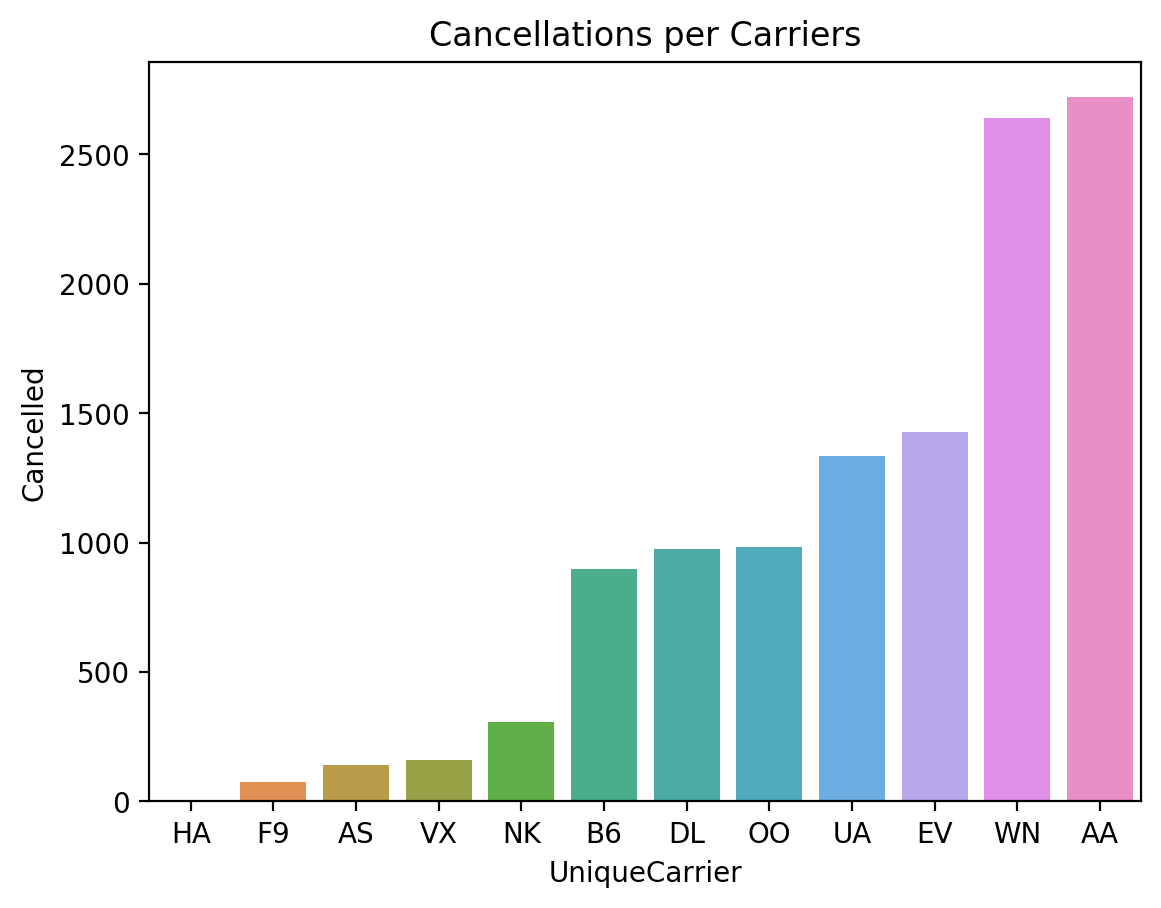

In [40]:
# Plotting the cancellations per carrier on a bar plot
g_bar=sns.barplot(x="UniqueCarrier", y="Cancelled", data=df_carrier)
g_bar.set_title("Cancellations per Carriers")

2. Which airports had the cancelled flights in 2016?

In [41]:
# Sum of canceled daily flights:
dff_Origin_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().sort_values(ascending=False).reset_index()

#dff.head()
dff_Dest_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().sort_values(ascending=False).reset_index()

dff_Origin_airportcode.head()

,Origin,Cancelled
0,EWR,824
1,BWI,631
2,DCA,609
3,CLT,589
4,LGA,542


Text(0.5, 1.0, 'Cancellations per domestic US airports for January 2016')

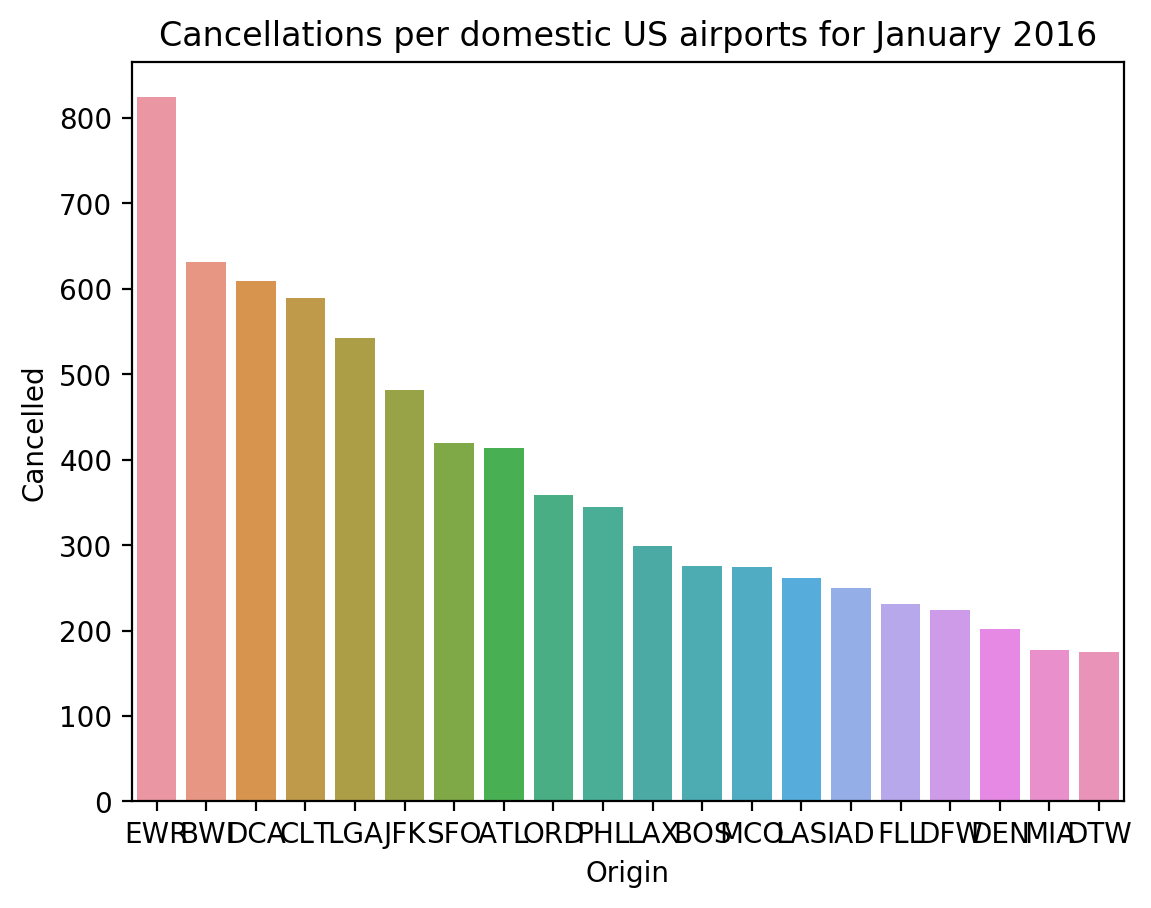

In [42]:
# Plotting the cancellations per domestic US airports for January 2016
g_bar=sns.barplot(x="Origin", y="Cancelled", data=dff_Origin_airportcode.iloc[0:20])
g_bar.set_title("Cancellations per domestic US airports for January 2016")

3. How do the various airlines compare when it came to reasons for cancelled flights?

[Text(0, 0, 'Carrier'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'National Air System')]

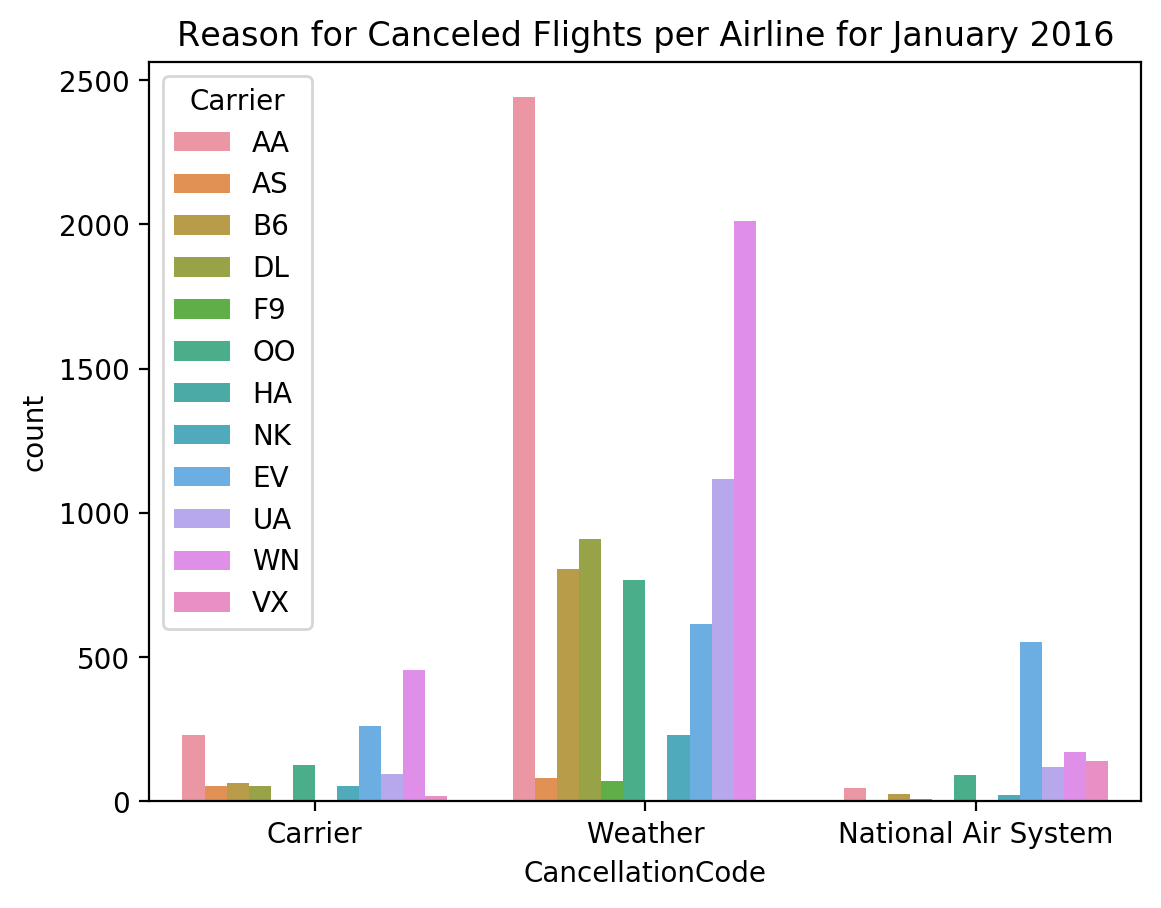

In [43]:
# Plotting the reasons for cancelled flights per airline for January 2016
g=sns.countplot(data=flights_df,
              x='CancellationCode',
              hue='Carrier'
             )
g.set_title('Reason for Canceled Flights per Airline for January 2016')
g.set_xticklabels(['Carrier','Weather','National Air System'])

4. How many flights per day were scheduled versus cancelled?

In [44]:
#for index, row in flights_df.iterrows():
# Sum of canceled daily flights:
dff = flights_df.groupby(["FlightDate"]).Cancelled.sum().reset_index()
#dff.head()

# Sum of total number of flights (since Quarter is always 1):
dff2 = flights_df.groupby(["FlightDate"]).Quarter.count().reset_index()
dff2.rename(columns={'Quarter':'Total_no_Flights'}, inplace=True)
#dff2.head()

dff_flights=pd.merge(dff, dff2, on = "FlightDate")
dff_flights.head()

,FlightDate,Cancelled,Total_no_Flights
0,2016-01-01,57,13019
1,2016-01-02,52,14869
2,2016-01-03,97,15878
3,2016-01-04,87,15570
4,2016-01-05,204,14582


[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09'),
 Text(0, 0, '01/10'),
 Text(0, 0, '01/11'),
 Text(0, 0, '01/12'),
 Text(0, 0, '01/13'),
 Text(0, 0, '01/14'),
 Text(0, 0, '01/15'),
 Text(0, 0, '01/16'),
 Text(0, 0, '01/17'),
 Text(0, 0, '01/18'),
 Text(0, 0, '01/19'),
 Text(0, 0, '01/20'),
 Text(0, 0, '01/21'),
 Text(0, 0, '01/22'),
 Text(0, 0, '01/23'),
 Text(0, 0, '01/24'),
 Text(0, 0, '01/25'),
 Text(0, 0, '01/26'),
 Text(0, 0, '01/27'),
 Text(0, 0, '01/28'),
 Text(0, 0, '01/29'),
 Text(0, 0, '01/30'),
 Text(0, 0, '01/31')]

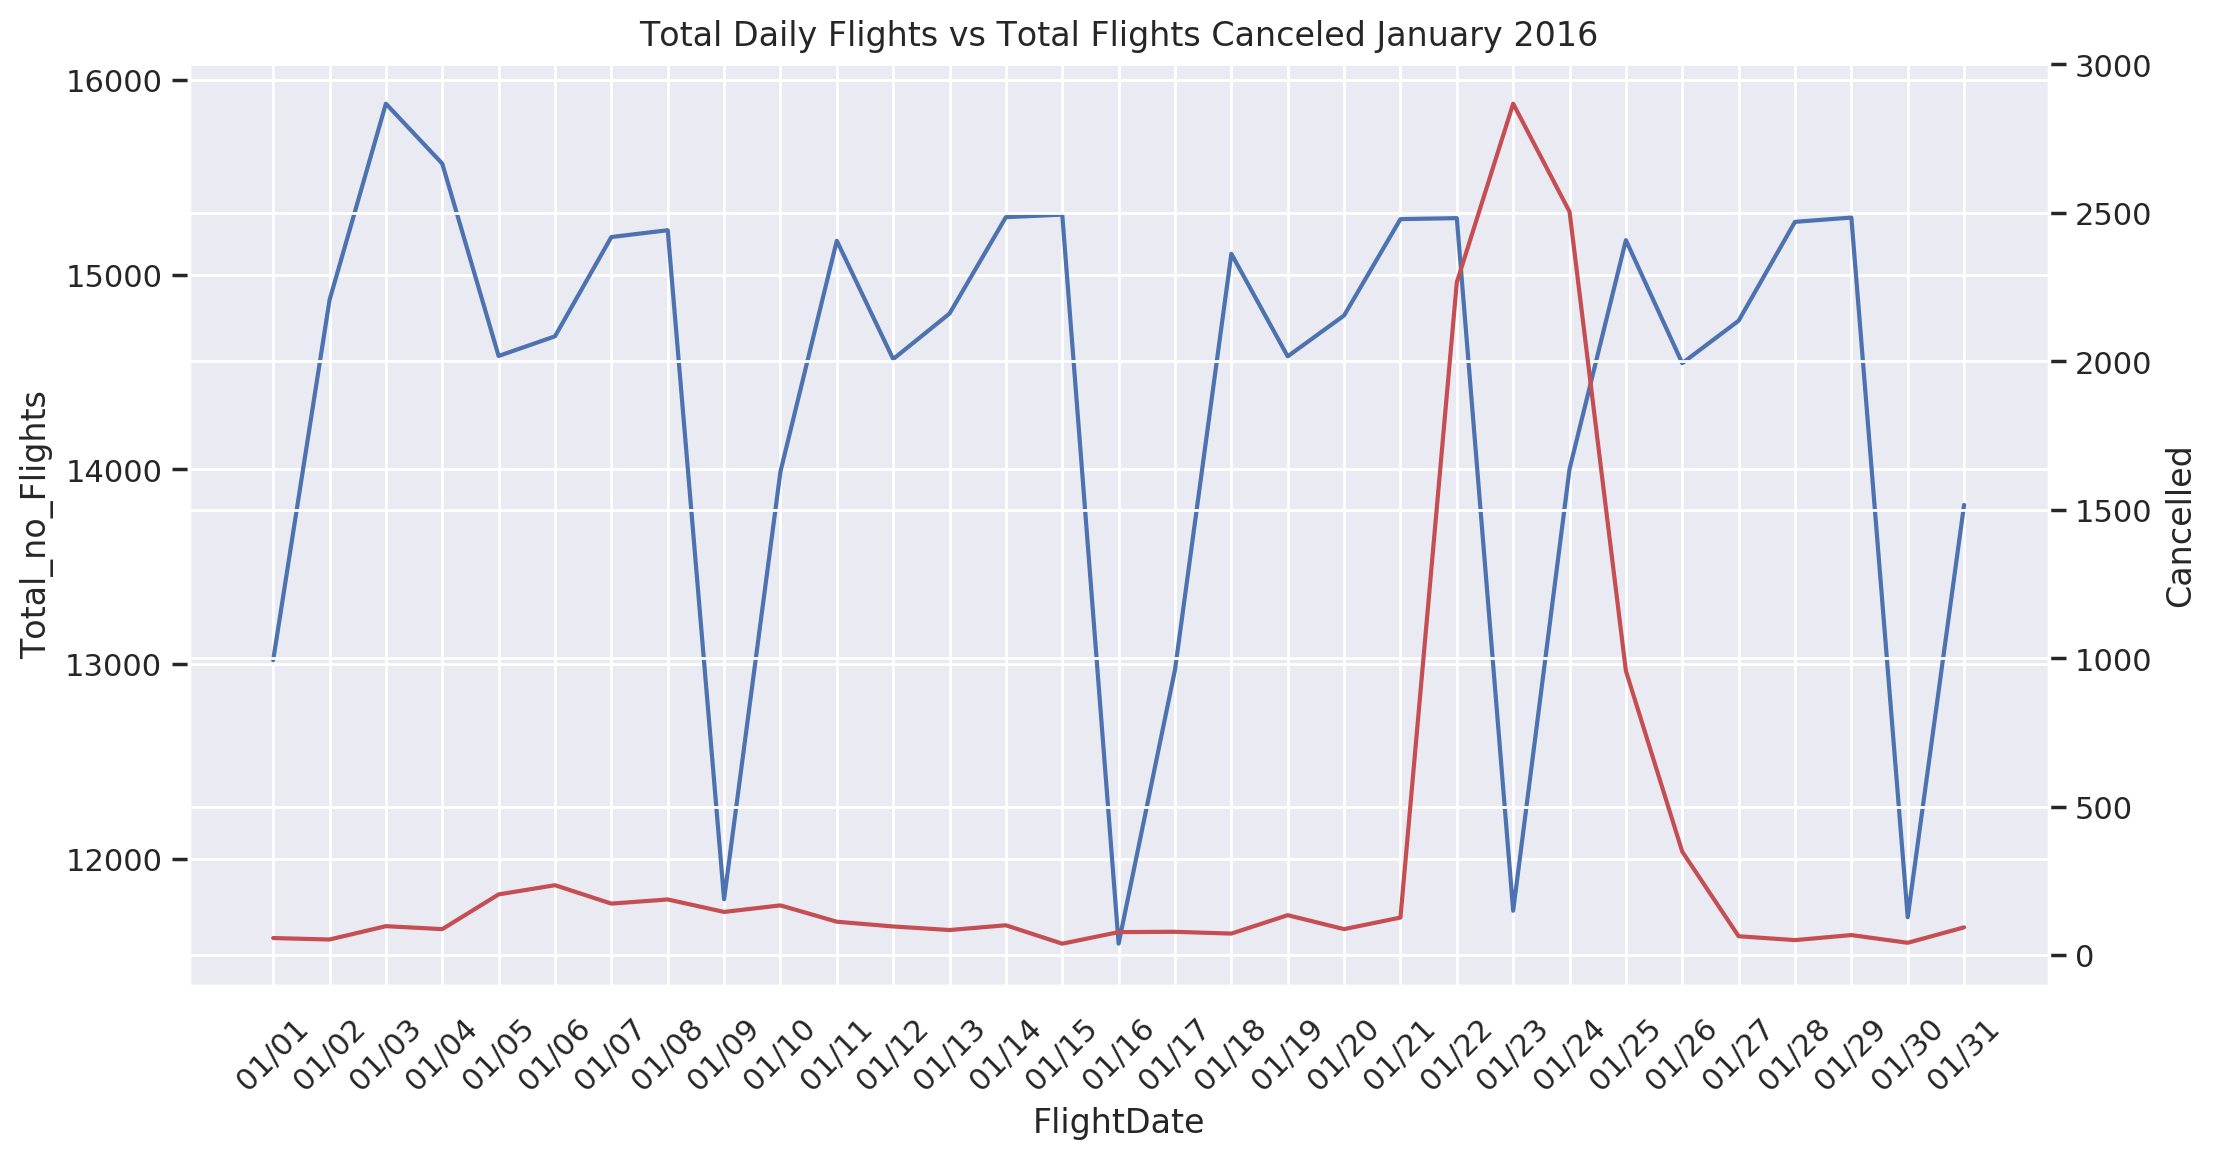

In [45]:
sns.set(rc={'figure.figsize':(10,7)})

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Total_no_Flights", ax = ax1, color = 'b') # plots the first set
g2 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Cancelled", ax = ax2, color = 'r') # plots the second set 
#g3 = sns.lineplot(data = df, x = x1, y = y3, ax = ax3, color = y3_color)

#g_line = sns.lineplot(x="FlightDate", y="Total_no_Flights", data=dff_flights)
#g_line.add_lineplot(x="FlightDate",y="Cancelled",data=dff_flights)
g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)

5. Which day of the week and month has the most cancellations?

In [46]:
# Looking at flight cancellations per day of month
df_dayofmonth = flights_df.groupby(["DayofMonth"]).Cancelled.sum().sort_values(ascending=False).reset_index()
df_dayofmonth.head(10)

,DayofMonth,Cancelled
0,23,2868
1,24,2504
2,22,2266
3,25,957
4,26,348
5,6,235
6,5,204
7,8,187
8,7,173
9,10,167


Text(0.5, 1.0, 'Cancellations per Day of Month')

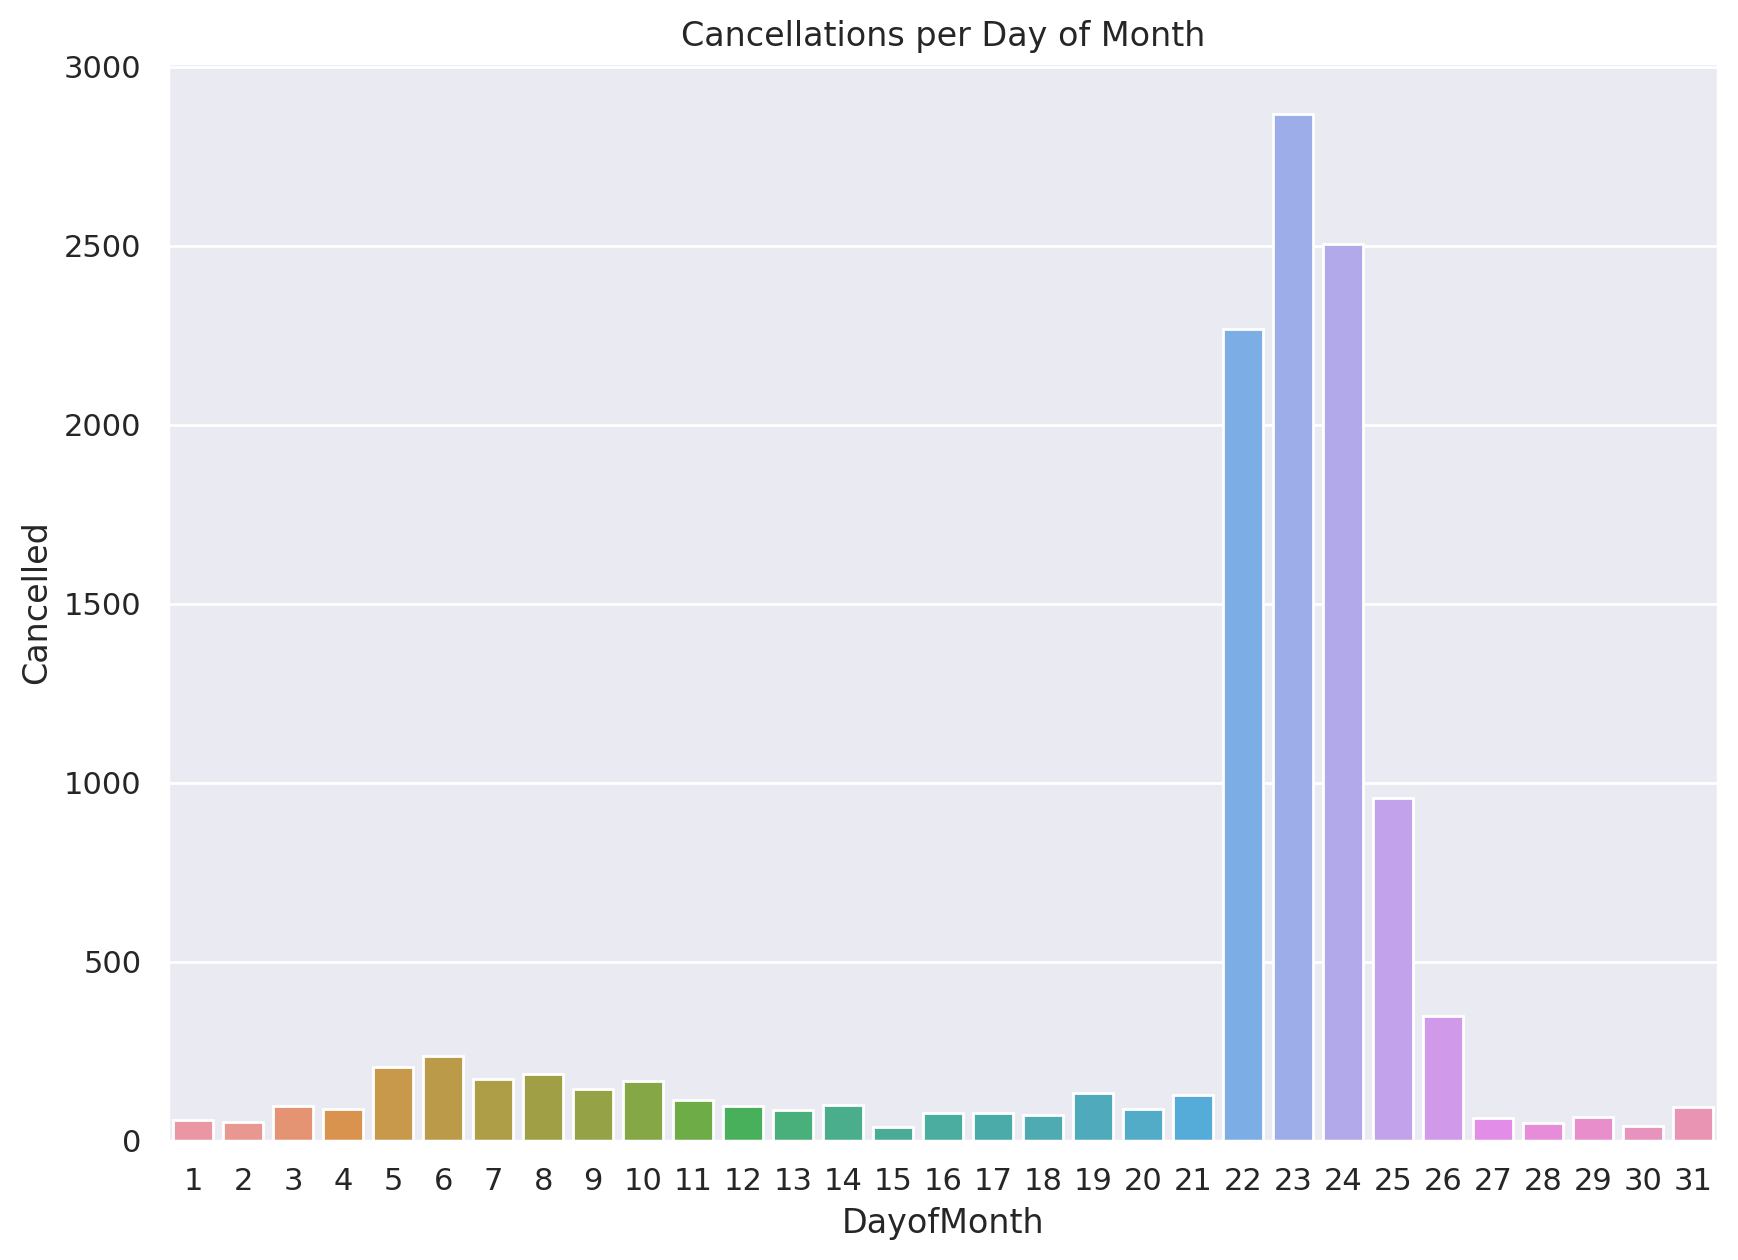

In [47]:
# Plot flight cancellations per day of month
g_bar=sns.barplot(x="DayofMonth", y="Cancelled", data=df_dayofmonth)
g_bar.set_title("Cancellations per Day of Month")

In [48]:
# Looking at flight cancellations per day of week
df_DayOfWeek = flights_df.groupby(["DayOfWeek"]).Cancelled.sum().sort_values(ascending=False).reset_index()
df_DayOfWeek.head(10)

,DayOfWeek,Cancelled
0,6,3183
1,7,2939
2,5,2615
3,1,1228
4,2,782
5,3,469
6,4,449


Text(0.5, 1.0, 'Cancellations per Day Of Week')

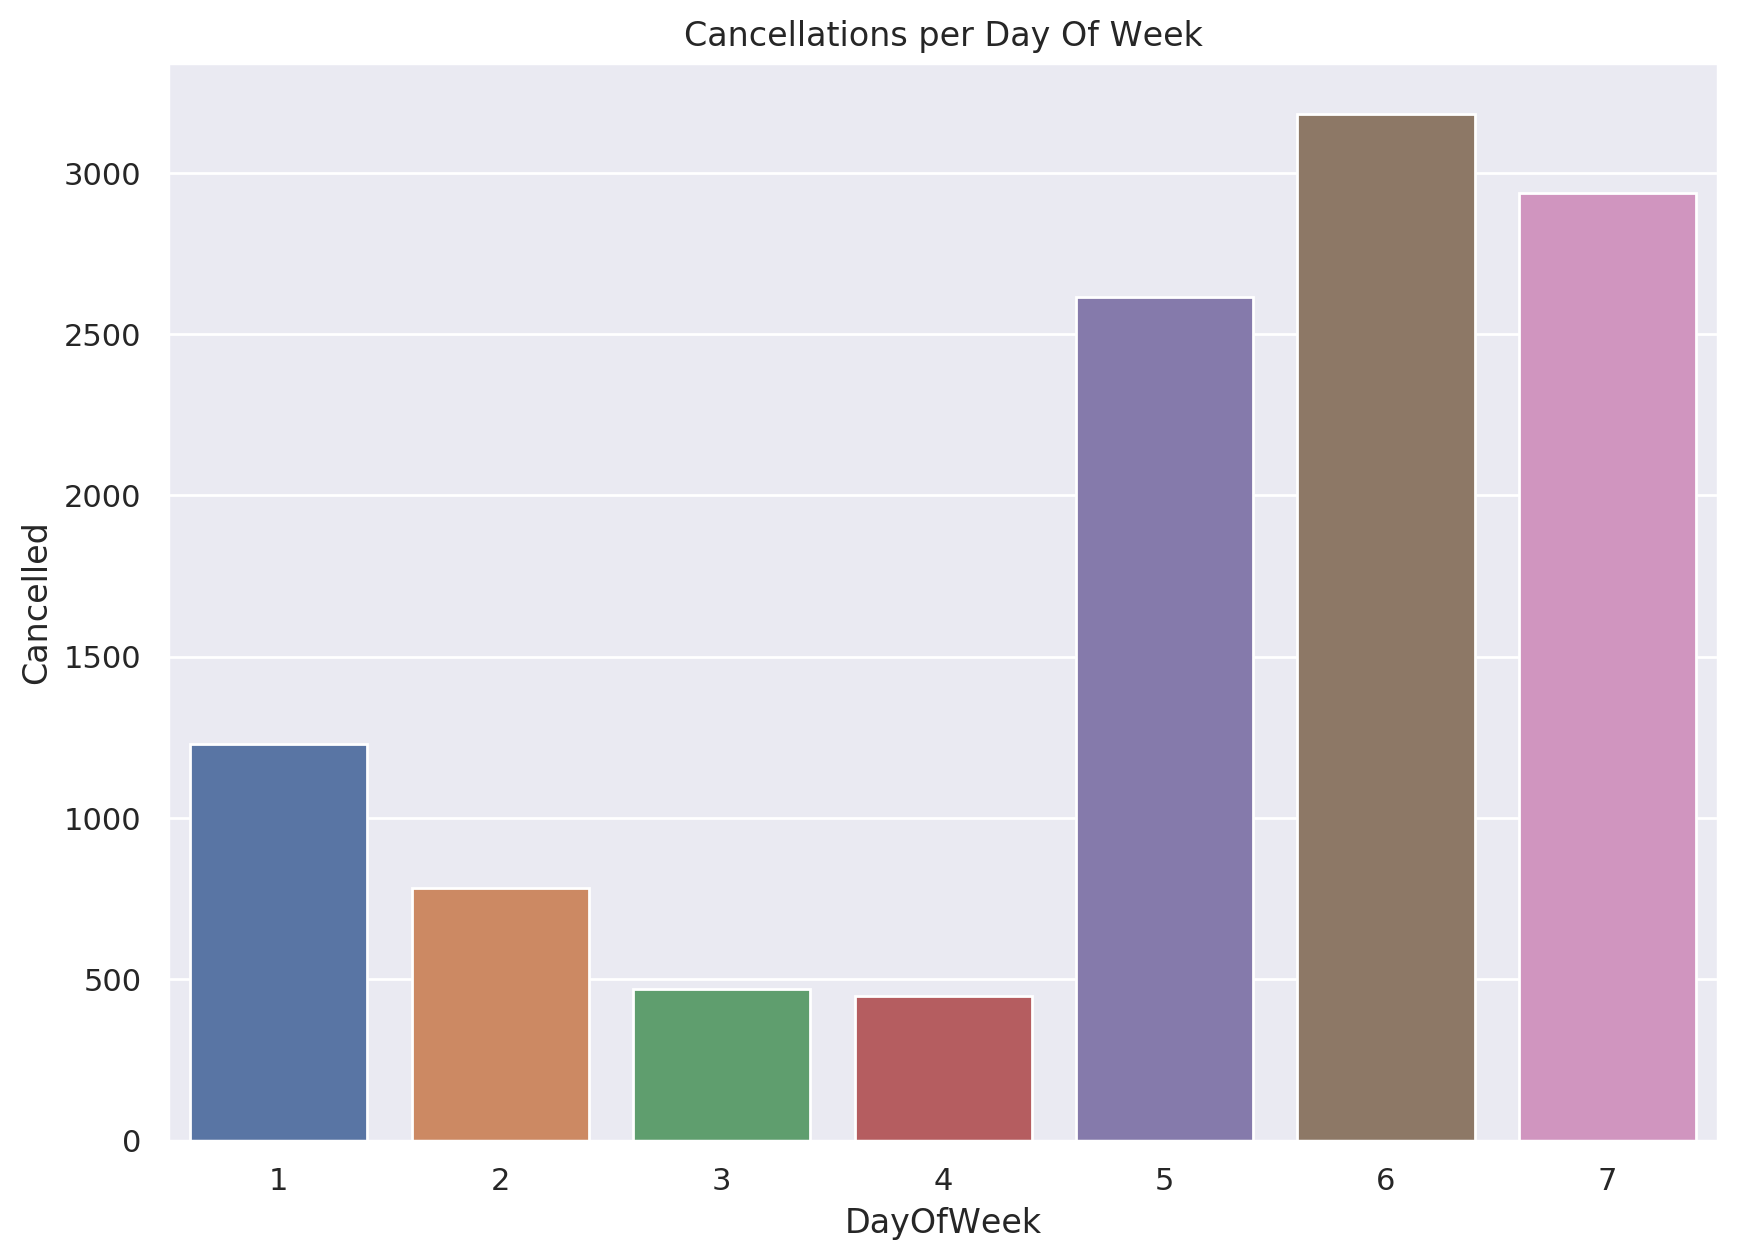

In [49]:
# Plot flight cancellations per day of week
g_bar=sns.barplot(x="DayOfWeek", y="Cancelled", data=df_DayOfWeek)
g_bar.set_title("Cancellations per Day Of Week")

6. What is the proportion of cancelled flights to total number of flights per airport?

In [50]:
# Sum of cancelled flights from each airport in 2016
dff_Origin_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().reset_index()
dff_Origin_airportcode.head()

,Origin,Cancelled
0,ABE,8
1,ABQ,12
2,ABR,0
3,ABY,0
4,ACT,0


In [51]:
# Sum of total number of flights from each airport in 2016
df_total_flights_per_airport = flights_df.groupby(['Origin'])['Origin'].count().reset_index(name='Total Flights') 
df_total_flights_per_airport.head()

,Origin,Total Flights
0,ABE,180
1,ABQ,1443
2,ABR,62
3,ABY,79
4,ACT,145


In [52]:
# Proportion of cancelled flights to total number of flights per airport
df_prop = pd.DataFrame((dff_Origin_airportcode['Cancelled']/df_total_flights_per_airport['Total Flights'])*100, columns=['Proportion %'])
df_prop['Origin'] = sorted(flights_df.Origin.unique())

# Sorting the dataframe to show the airport with the highest %
df_prop = df_prop.sort_values(by=['Proportion %'], ascending=False)
df_prop

,Proportion %,Origin
273,35.652174,SUN
190,31.250000,MMH
86,11.320755,EKO
132,9.854158,IAD
94,9.664555,EWR
...,...,...
51,0.000000,CDC
144,0.000000,ITO
143,0.000000,ITH
243,0.000000,ROW


Text(0.5, 1.0, 'Proportion of Cancelled Flights to Total Number of Flights')

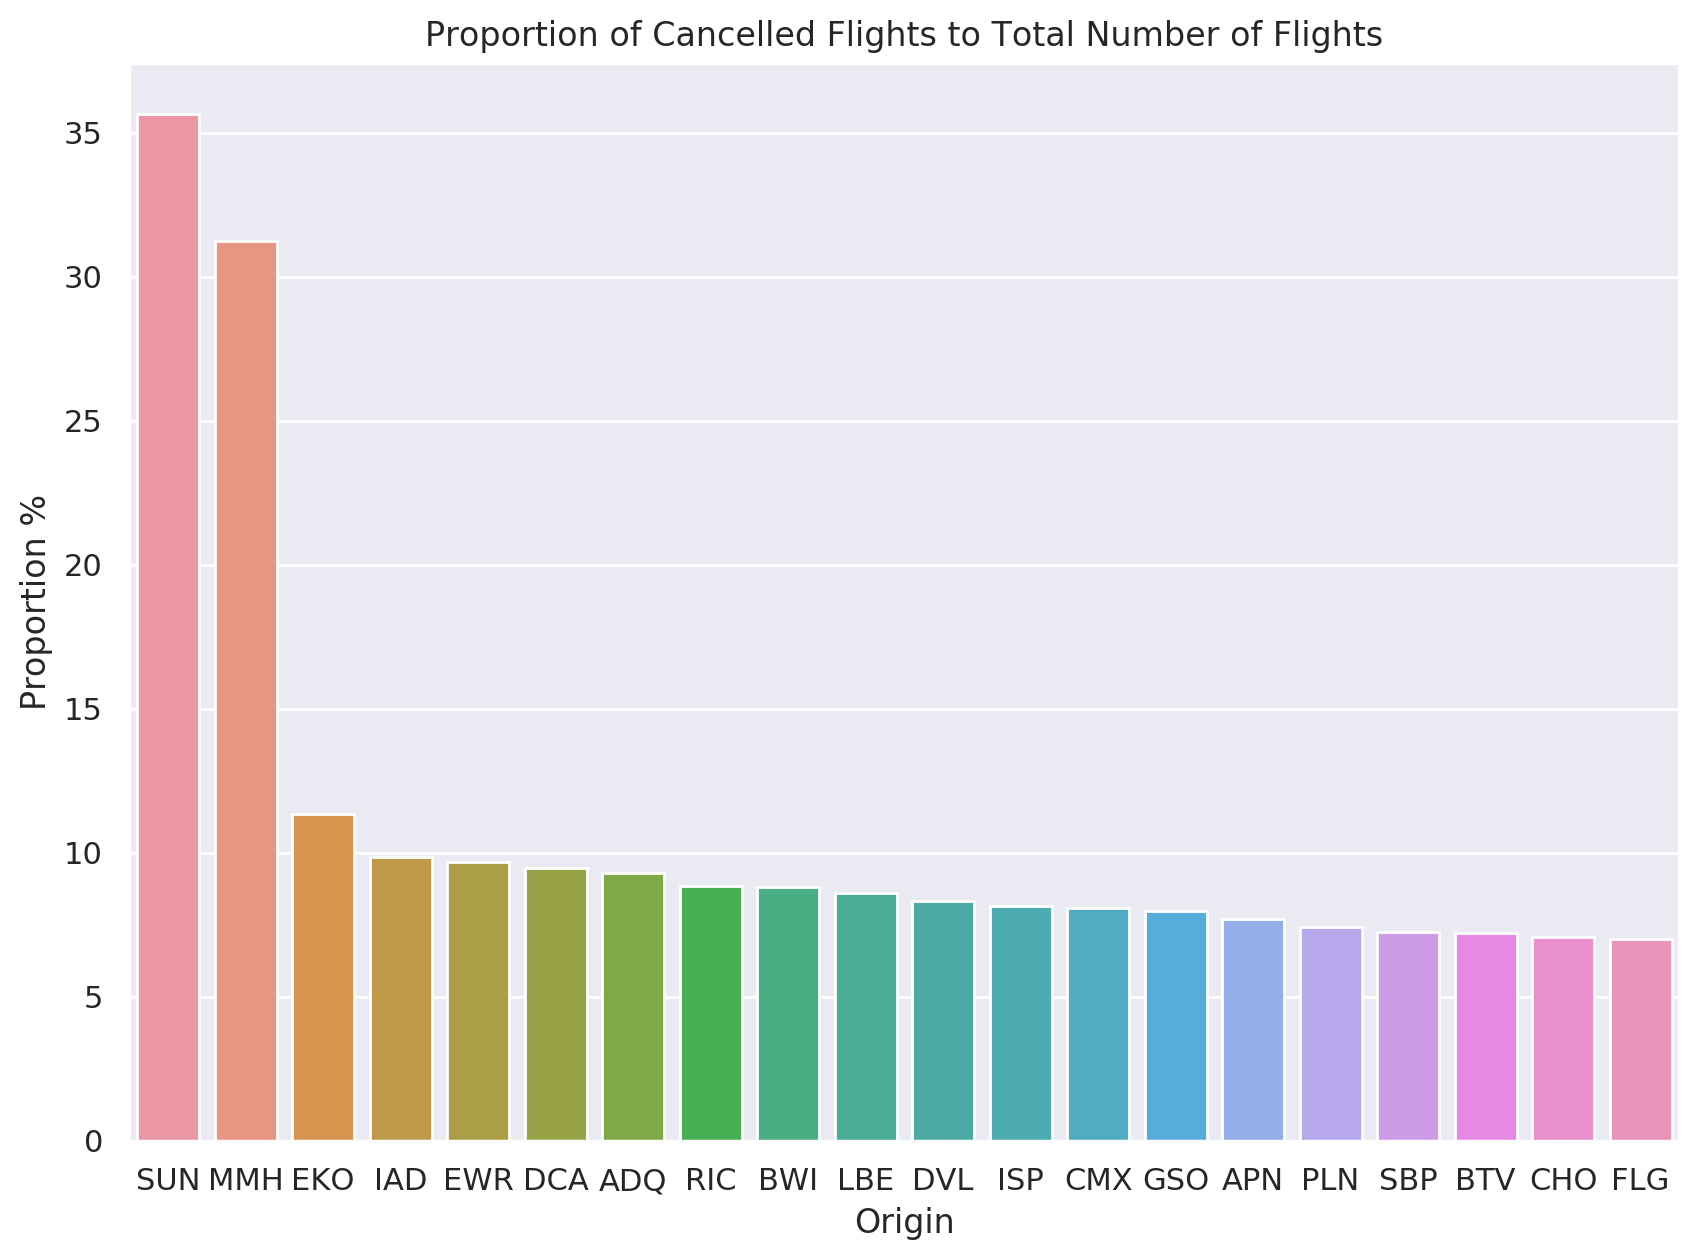

In [53]:
# Plot proportion of cancelled flights to total number of flights
g_bar=sns.barplot(x="Origin", y="Proportion %", data=df_prop.iloc[0:20])
g_bar.set_title("Proportion of Cancelled Flights to Total Number of Flights")

Section 2 - Detecting Data-Quality Issues:

Checking on Data Types and Missing Values:

In [54]:
# Summarize the flights dataset
def summarize(flights_df):
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    percentage_missing = []
    
    for item in flights_df.columns:
        variables.append(item)
        dtypes.append(flights_df[item].dtype)
        count.append(len(flights_df[item]))
        unique.append(len(flights_df[item].unique()))
        missing.append(flights_df[item].isna().sum())
        percentage_missing.append(round((flights_df[item].isna().sum() / len(flights_df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing,
        'percentage_missing': percentage_missing
    })    
        
    return output

In [55]:
summarize(flights_df)

,variable,dtype,count,unique,missing,percentage_missing
0,Unnamed: 0,int64,445827,445827,0,0.0
1,Year,int64,445827,1,0,0.0
2,Quarter,int64,445827,1,0,0.0
3,Month,int64,445827,1,0,0.0
4,DayofMonth,int64,445827,31,0,0.0
...,...,...,...,...,...,...
79,Div2AirportID,float64,445827,6,445821,100.0
80,Div2AirportSeqID,float64,445827,6,445821,100.0
81,Div2WheelsOn,float64,445827,7,445821,100.0
82,Div2TotalGTime,float64,445827,5,445821,100.0


In [56]:
# Checking missing values on target variable - cancelled flights
flights_df['Cancelled'].isna().sum()

0

In [57]:
# Filtering columns that has more than 80% missing values
summarize(flights_df).loc[summarize(flights_df)['percentage_missing'] >= 80.0]

,variable,dtype,count,unique,missing,percentage_missing
49,CancellationCode,object,445827,4,434162,97.38
57,CarrierDelay,float64,445827,580,374945,84.10
58,WeatherDelay,float64,445827,315,374945,84.10
59,NASDelay,float64,445827,296,374945,84.10
60,SecurityDelay,float64,445827,58,374945,84.10
61,LateAircraftDelay,float64,445827,392,374945,84.10
62,FirstDepTime,float64,445827,977,443275,99.43
63,TotalAddGTime,float64,445827,150,443275,99.43
64,LongestAddGTime,float64,445827,148,443275,99.43
66,DivReachedDest,float64,445827,3,444963,99.81


Checking on Class imbalance:

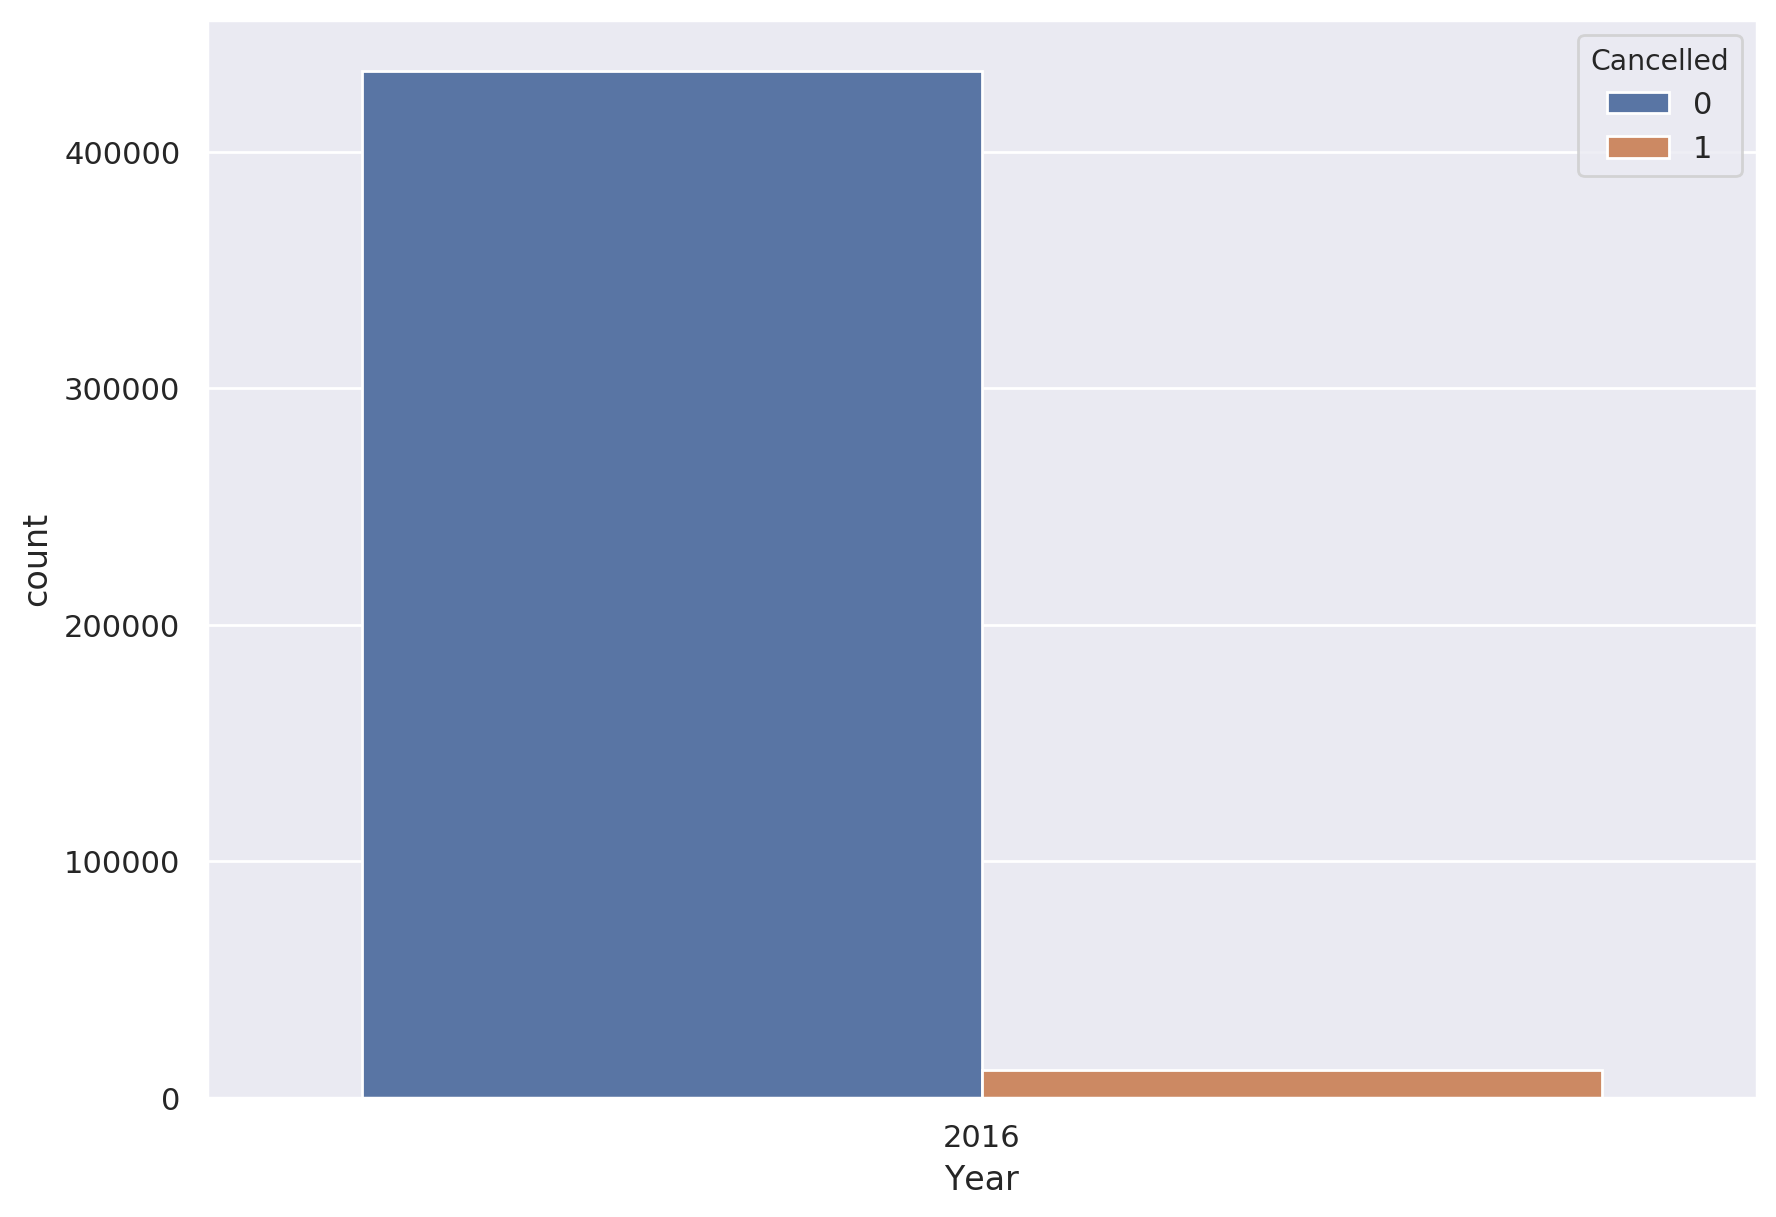

In [58]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
sns.countplot(data=flights_df, x="Year", hue="Cancelled")
plt.show()

Data Clean/Prep
prepare data so flights can be matched up to proper weather data:

In [65]:
# remove prefix K on airport codes so we can match them to flight data:

weather_df['AirportCode'] = weather_df['AirportCode'].str[1:]
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [66]:
# Prepare flights data for datetime (timestamp) format
# by changing the type of CRSDepTime from int to string:

flights_df['CRSDepTime'] = flights_df['CRSDepTime'].astype('string')

In [67]:
# rename weather data 2016 start and end datetimes:

weather_df.rename(columns={'StartTime(UTC)':'StartTime'}, inplace=True)
weather_df.rename(columns={'EndTime(UTC)':'EndTime'}, inplace=True)
weather_df.rename(columns={'EndTime(UTC)':'EndTime'}, inplace=True)

In [69]:
weather_df.rename(columns={'Precipitation(in)':'Precipitation'}, inplace=True)

In [70]:
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [97]:
# Clean up weather for JFK data where there is a T that stands for "trace":

JFK_weather_data['Precipitation']=JFK_weather_data['Precipitation'].replace(['T'], 0.0001)
JFK_weather_data['Snow_Depth']=JFK_weather_data['Snow_Depth'].replace(['T'], 0.0001)
JFK_weather_data['New_Snow']=JFK_weather_data['New_Snow'].replace(['T'], 0.0001)

In [98]:
# Drop the last rows that give
# summary statistics:

JFK_weather_data.drop(JFK_weather_data.tail(3).index,inplace=True)

In [99]:
# convert the Date column into the
# proper format:

JFK_weather_data['Date'] = pd.to_datetime(JFK_weather_data['Date'], 
                                          format='%m/%d/%Y').dt.date
#convert date to YYYYMMDD format

In [100]:
JFK_weather_data.head(31)    #January

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0
5,2016-01-06,40.0,21.0,30.5,-3.2,34,0,0,0,0
6,2016-01-07,46.0,27.0,36.5,3,28,0,0,0,0
7,2016-01-08,47.0,32.0,39.5,6.1,25,0,0,0,0
8,2016-01-09,53.0,40.0,46.5,13.3,18,0,0.02,0,0
9,2016-01-10,58.0,41.0,49.5,16.4,15,0,1.28,0,0


For the JFK flights only:

In [75]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
dff_Origin_JFK = flights_df[flights_df["Origin"]=="JFK"].reset_index()
#data[data['Value'] == True]
dff_Origin_JFK.head()

,index,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,88,2016,1,1,1,5,2016-01-01,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,89,2016,1,1,2,6,2016-01-02,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,90,2016,1,1,3,7,2016-01-03,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,91,2016,1,1,4,1,2016-01-04,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,92,2016,1,1,5,2,2016-01-05,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Fill CRSDepTime with the right amount of zeros to the left and right
# depending on the original length of the field:

for x in range(0,len(dff_Origin_JFK)):
#for x in range(0,5):
    if len(dff_Origin_JFK.loc[x,'CRSDepTime']) == 4:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(6,'0')
    if len(dff_Origin_JFK.loc[x,'CRSDepTime']) == 2:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(4,'0')
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].rjust(6,'0')
    else:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(5,'0')
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].rjust(6,'0')

In [101]:
for x in range(len(dff_Origin_JFK)):
    dff_Origin_JFK.loc[x,'CRSDepTime']=pd.to_datetime(dff_Origin_JFK.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')

In [102]:
dff_Origin_JFK['FlightDate'] = dff_Origin_JFK['FlightDate'].astype(str) + ' ' + dff_Origin_JFK['CRSDepTime'].astype(str) 

In [103]:
dff_Origin_JFK.drop(['Unnamed: 0'],axis=1,inplace=True)

In [104]:
dff_Origin_JFK.head()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,2016,1,1,1,5,2016-01-01 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,2016,1,1,2,6,2016-01-02 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,2016,1,1,3,7,2016-01-03 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,2016,1,1,4,1,2016-01-04 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,2016,1,1,5,2,2016-01-05 18:20:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
dff_Origin_JFK['FlightDate'] = pd.to_datetime(dff_Origin_JFK['FlightDate'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [106]:
dff_Origin_JFK_mod=dff_Origin_JFK.copy()
dff_Origin_JFK_mod['FlightDate']=dff_Origin_JFK_mod['FlightDate'].dt.date

In [107]:
dff_Origin_JFK_mod.head()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,2016,1,1,1,5,2016-01-01,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,2016,1,1,2,6,2016-01-02,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,2016,1,1,3,7,2016-01-03,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,2016,1,1,4,1,2016-01-04,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,2016,1,1,5,2,2016-01-05,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For the entire flights dataframe:

# Fill CRSDepTime with the right amount of zeros to the left and right
# depending on the original length of the field:

for x in range(0,len(flights_df)):
    if len(flights_df.loc[x,'CRSDepTime']) == 4:
        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(6,'0')
    if len(flights_df.loc[x,'CRSDepTime']) == 2:
        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(4,'0')
        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].rjust(6,'0')
    else:
        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(5,'0')
        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].rjust(6,'0')

for x in range(len(flights_df)):
    flights_df.loc[x,'CRSDepTime']=pd.to_datetime(flights_df.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')

flights_df['FlightDate'] = flights_df['FlightDate'].astype(str) + ' ' + flights_df['CRSDepTime'].astype(str) 

airport codes dataframe cleanup:

In [109]:
# Split up the "Description" field in the original aiport dataframe
# So that fields mean something more - the airport code is followed by
# the related airport name and it's city and state:

AirportCodes_df[['City_State', 'Airport']] = AirportCodes_df['Description'].str.split(':', expand=True)
AirportCodes_df= AirportCodes_df.drop('Description', axis=1)
AirportCodes_df[['City', 'State']] = AirportCodes_df['City_State'].str.split(',', n=1, expand=True)
AirportCodes_df= AirportCodes_df.drop('City_State', axis=1)

In [110]:
AirportCodes_df['City']=AirportCodes_df['City'].astype('string')
AirportCodes_df['Airport']=AirportCodes_df['Airport'].astype('string')
AirportCodes_df['State']=AirportCodes_df['State'].astype('string')
AirportCodes_df['Code']=AirportCodes_df['Code'].astype('string')

In [111]:
AirportCodes_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [112]:
AirportCodes_df.head()

,Code,Airport,City,State
0,01A,Afognak Lake Airport,Afognak Lake,AK
1,03A,Bear Creek Mining Strip,Granite Mountain,AK
2,04A,Lik Mining Camp,Lik,AK
3,05A,Little Squaw Airport,Little Squaw,AK
4,06A,Kizhuyak Bay,Kizhuyak,AK


Obtain subsets of cleaner weather_2016 data for JFK only:

In [113]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
dff_Weather_JFK = weather_df[weather_df["AirportCode"]=="JFK"].reset_index()
#data[data['Value'] == True]
dff_Weather_JFK.head()

,index,Unnamed: 0,EventId,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,52242,335383,W-340157,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
1,52243,335384,W-340158,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
2,52244,335385,W-340159,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
3,52245,335386,W-340160,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
4,52246,335387,W-340161,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0


In [119]:
weather_df['StartTime'] = pd.to_datetime(weather_df.StartTime, format='%Y-%m-%d %H:%M:%S')

dff_Weather_Jan = weather_df[weather_df["StartTime"].dt.month == 1].reset_index()
#data[data['Value'] == True]
dff_Weather_Jan.head()

,index,Unnamed: 0,EventId,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


Feature engineering:

In [120]:
# Find all possible unique values for weather type
# and weather severity in the weather dataframe:

Type_unique=weather_df['Type'].unique()
Severity_unique=weather_df['Severity'].unique()

In [121]:
# Generate all possible combinations for weather
# type and severity so that we assign a code called weather_code
# This feature can be used by data science teams to see if there is a
# relationship with cancellations and the combination of such 
# weather conditions:

all_combinations = list(itertools.product(Type_unique, Severity_unique))
Weather_comb_var = pd.DataFrame(all_combinations, columns=['Type','Severity'])

Add new feature to weather_2016 JFK data:

In [122]:
# For JFK location ONLY:

weather_code = []

for i in dff_Weather_JFK.index:
    for x in Weather_comb_var.index:
        if (dff_Weather_JFK.loc[i, 'Type'] == Weather_comb_var.loc[x,'Type']) & (dff_Weather_JFK.loc[i, 'Severity'] == Weather_comb_var.loc[x,'Severity']):
            weather_code.append(x)
 
dff_Weather_JFK['Weather_Comb_Var'] = weather_code

In [123]:
dff_Weather_JFK.drop(["Unnamed: 0","EventId"], axis=1, inplace=True)

In [124]:
dff_Weather_JFK['StartTime'] = pd.to_datetime(dff_Weather_JFK['StartTime'], 
                                          format='%Y-%m-%d %H:%M:%S')
dff_Weather_JFK['EndTime'] = pd.to_datetime(dff_Weather_JFK['EndTime'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [126]:
dff_Weather_JFK.head(5)

,index,Type,Severity,StartTime,EndTime,Precipitation,TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,Weather_Comb_Var
0,52242,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
1,52243,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
2,52244,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
3,52245,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,27
4,52246,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26


In [127]:
# Took too long:

#weather_code2 = []

#for i in weather_df.index:
#    for x in Weather_comb_var.index:
#        if (weather_df.loc[i, 'Type'] == Weather_comb_var.loc[x,'Type']) & (weather_df.loc[i, 'Severity'] == Weather_comb_var.loc[x,'Severity']):
#            weather_code2.append(x)
 
#weather_df['Weather_Comb_Var'] = weather_code2

In [128]:
weather_df.drop(["Unnamed: 0","EventId"], axis=1, inplace=True)

In [129]:
weather_df['StartTime'] = pd.to_datetime(weather_df['StartTime'], 
                                          format='%Y-%m-%d %H:%M:%S')
weather_df['EndTime'] = pd.to_datetime(weather_df['EndTime'], 
                                          format='%Y-%m-%d %H:%M:%S')

check sizes of dataframes:

In [130]:
dff_Weather_JFK.shape

(443, 15)

In [131]:
dff_Origin_JFK.shape

(8027, 84)

In [132]:
Weather_comb_var.head(10)

,Type,Severity
0,Snow,Light
1,Snow,Severe
2,Snow,Moderate
3,Snow,Heavy
4,Snow,UNK
5,Snow,Other
6,Fog,Light
7,Fog,Severe
8,Fog,Moderate
9,Fog,Heavy


Combine features of interest:
Select Flight and WeatherUS_2016 features:

In [133]:
# Grap only the columns of interest from JFK flights data:
JFK_Flights_FS = dff_Origin_JFK.copy()
JFK_Flights_FS = JFK_Flights_FS[["FlightDate",
                                "DayOfWeek",
                                "AirlineID",
                                "Origin",
                                "Dest",
                                "WeatherDelay", 
                                "CancellationCode",
                                "Cancelled"]]

In [134]:
# Pre-assign weather type/severity conditions
# as fair before modifying based on the watherUS_2016 data
# if the combination variable is 99, the weather was fair and normal:

JFK_Flights_FS['Origin_Weather_Type'] = 'Fair'
JFK_Flights_FS['Origin_Weather_Severity'] = 'Normal'
JFK_Flights_FS['Origin_Weather_Comb'] = 99
JFK_Flights_FS['Origin_Weather_Precipitation'] = 0.0
JFK_Flights_FS['Dest_Weather_Type'] = 'Fair'
JFK_Flights_FS['Dest_Weather_Severity'] = 'Normal'
JFK_Flights_FS['Dest_Weather_Comb'] = 99
JFK_Flights_FS['Dest_Weather_Precipitation'] = 0.0

In [135]:
# If the flight is not canceled, the code is 'Z':

JFK_Flights_FS['CancellationCode'].replace(np.nan, value='Z', inplace = True)
JFK_Flights_FS['WeatherDelay'].replace(np.nan, value=0.0, inplace = True)

In [139]:
JFK_Flights_FS.head(500)

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,CancellationCode,Cancelled,Origin_Weather_Type,Origin_Weather_Severity,Origin_Weather_Comb,Origin_Weather_Precipitation,Dest_Weather_Type,Dest_Weather_Severity,Dest_Weather_Comb,Dest_Weather_Precipitation
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2016-01-17 10:30:00,7,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
496,2016-01-18 10:30:00,1,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
497,2016-01-19 10:30:00,2,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0
498,2016-01-20 10:30:00,3,19805,JFK,SFO,0.0,Z,0,Fair,Normal,99,0.0,Fair,Normal,99,0.0


Match Flight Dates with WeatherUS_2016 dates to Add weather features:

In [141]:
for i in range(0,len(JFK_Flights_FS)):
    for x in range(0,len(dff_Weather_JFK)):
        if (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_JFK.loc[x,'StartTime'].date()) | (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_JFK.loc[x,'EndTime'].date()):
            #print("match")
            #print(i)
            JFK_Flights_FS.loc[i,'Origin_Weather_Type'] = dff_Weather_JFK.loc[x,'Type']
            JFK_Flights_FS.loc[i,'Origin_Weather_Severity'] = dff_Weather_JFK.loc[x,'Severity']
            JFK_Flights_FS.loc[i,'Origin_Weather_Comb'] = dff_Weather_JFK.loc[x,'Weather_Comb_Var']
            JFK_Flights_FS.loc[i,'Origin_Weather_Precipitation'] = dff_Weather_JFK.loc[x,'Precipitation']
            # exit out of the weather dataframe once a match is found:
            x=len(dff_Weather_JFK)+1

In [142]:
JFK_Flights_FS.drop(['Dest_Weather_Comb','Dest_Weather_Type',
                    'Dest_Weather_Severity',
                    'Dest_Weather_Precipitation'],axis=1,inplace=True)

In [143]:
JFK_Flights_FS.to_csv('s3://sagemaker-us-east-1-501175457253/airline_data/JFK_Flight_Weather_Prelim.csv')

Match FlightDates and detailed JFK weather data:

In [144]:
JFK_weather_data.head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0


In [145]:
JFK_Flights_FS['Origin_MaxTemp'] = 0.0
JFK_Flights_FS['Origin_MinTemp'] = 0
JFK_Flights_FS['Origin_AvgTemp'] = 0
JFK_Flights_FS['Origin_DepTemp'] = 0.0
JFK_Flights_FS['Origin_HDD'] = 0.0
JFK_Flights_FS['Origin_CDD'] = 0.0
JFK_Flights_FS['Origin_New_Snow'] = 0.0
JFK_Flights_FS['Origin_Snow_Depth'] = 0.0

In [146]:
for i in range(0,len(JFK_Flights_FS)):
    for x in range(0,len(JFK_weather_data)):
        if (JFK_Flights_FS.loc[i,'FlightDate'].date() == JFK_weather_data.loc[x,'Date']):
            #print("match")
            #print(i)
            JFK_Flights_FS.loc[i,'Origin_MaxTemp'] = JFK_weather_data.loc[x,'MaxTemp']
            JFK_Flights_FS.loc[i,'Origin_MinTemp'] = JFK_weather_data.loc[x,'MinTemp']
            JFK_Flights_FS.loc[i,'Origin_AvgTemp'] = JFK_weather_data.loc[x,'AvgTemp']
            JFK_Flights_FS.loc[i,'Origin_DepTemp'] = JFK_weather_data.loc[x,'DepTemp']
            JFK_Flights_FS.loc[i,'Origin_HDD'] = JFK_weather_data.loc[x,'HDD']
            JFK_Flights_FS.loc[i,'Origin_CDD'] = JFK_weather_data.loc[x,'CDD']
            JFK_Flights_FS.loc[i,'Origin_New_Snow'] = JFK_weather_data.loc[x,'New_Snow']
            JFK_Flights_FS.loc[i,'Origin_Snow_Depth'] = JFK_weather_data.loc[x,'Snow_Depth']
                  
            # exit out of the weather dataframe once a match is found:
            x=len(JFK_weather_data)+1

In [147]:
JFK_Flights_FS.head(700)

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,CancellationCode,Cancelled,Origin_Weather_Type,Origin_Weather_Severity,Origin_Weather_Comb,Origin_Weather_Precipitation,Origin_MaxTemp,Origin_MinTemp,Origin_AvgTemp,Origin_DepTemp,Origin_HDD,Origin_CDD,Origin_New_Snow,Origin_Snow_Depth
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,44.0,36,40,5.4,25,0,0,0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,41.0,34,37.5,3.1,27,0,0,0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,48.0,35,41.5,7.3,23,0,0,0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,38.0,15,26.5,-7.5,38,0,0,0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,29.0,12,20.5,-13.4,44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2016-01-21 17:30:00,4,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,39.0,27,33,0.8,32,0,0,0
696,2016-01-22 17:30:00,5,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,30.0,21,25.5,-6.7,39,0,0.2,0
697,2016-01-23 17:30:00,6,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.06,31.0,26,28.5,-3.7,36,0,30.3,7
698,2016-01-24 17:29:00,7,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.00,35.0,19,27,-5.2,38,0,0.1,28


In [148]:
JFK_Flights_FS.to_csv('s3://sagemaker-us-east-1-501175457253/airline_data/JFK_Flight_Weather_Data_FinalSet.csv')


In [161]:
# save new dataframes in S3 bucket as csv:
dff_Origin_JFK.to_csv('s3://sagemaker-us-east-1-501175457253/airline_data/Flights_JFK/Flights_JFK_clean.csv')
dff_Weather_JFK.to_csv('s3://sagemaker-us-east-1-501175457253/airline_data/Weather_JFK/Weather_JFK_clean.csv')

In [162]:
JFK_weather_data.to_csv('s3://sagemaker-us-east-1-501175457253/airline_data/JFK_weather_detailed/Weather_JFK__detailed_clean.csv')

In [163]:
dff_Origin_JFK_mod.to_csv('s3://sagemaker-us-east-1-501175457253/airline_data/Flights_JFK_mod/dff_Origin_JFK_mod.csv')

In [168]:
table_JFK_flights = 'Flights_JFK'
table_JFK_weather2016 = 'Weather2016_JFK6'
table_JFK_weather_detailed = 'Weather_detailed_JFK6'
table_JFK_flights_mod = 'Flights_JFK_mod'

In [169]:
JFK_flight_path = 's3://sagemaker-us-east-1-501175457253/airline_data/Flights_JFK'
JFK_flight_path_mod = 's3://sagemaker-us-east-1-501175457253/airline_data/Flights_JFK_mod'
JFK_weather_path = 's3://sagemaker-us-east-1-501175457253/airline_data/Weather_JFK'
JFK_weather_detailed_path = 's3://sagemaker-us-east-1-501175457253/airline_data/JFK_weather_detailed'

In [170]:
statement_flights_JFK = """CREATE EXTERNAL TABLE {}.{}(
         count int,
         Index int,
         Year	int,
         Quarter int,
         month int,
         DayofMonth 	int,         
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	string,
         Carrier	string,
         TailNum	string,
         FlightNum	string,
         OriginAirportID	string,
         OriginAirportSeqID	string,
         OriginCityMarketID	string,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	string,
         OriginStateName	string,
         OriginWac	string,
         DestAirportID	string,
         DestAirportSeqID	string,
         DestCityMarketID	string,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	string,
         DestStateName	string,
         DestWac	string,
         CRSDepTime	string,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	string,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	string,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_flights, JFK_flight_path
)


In [171]:
pd.read_sql(statement_flights_JFK, conn)

""


In [172]:
queryflightsJFK = "SELECT cancellationcode FROM {}.{} LIMIT 10".format(database_name, table_JFK_flights)
pd.read_sql(queryflightsJFK, conn)

,cancellationcode
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


In [173]:
statement_flights_JFK_mod = """CREATE EXTERNAL TABLE {}.{}(
         count int,
         Index int,
         Year	int,
         Quarter int,
         month int,
         DayofMonth 	int,         
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	string,
         Carrier	string,
         TailNum	string,
         FlightNum	string,
         OriginAirportID	string,
         OriginAirportSeqID	string,
         OriginCityMarketID	string,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	string,
         OriginStateName	string,
         OriginWac	string,
         DestAirportID	string,
         DestAirportSeqID	string,
         DestCityMarketID	string,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	string,
         DestStateName	string,
         DestWac	string,
         CRSDepTime	string,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	string,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	string,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_flights_mod, JFK_flight_path_mod
)

In [174]:
pd.read_sql(statement_flights_JFK_mod, conn)

""


In [175]:
queryflightsJFK_mod = "SELECT * FROM {}.{} LIMIT 10".format(database_name, table_JFK_flights_mod)
pd.read_sql(queryflightsJFK_mod, conn)

,count,index,year,quarter,month,dayofmonth,dayofweek,flightdate,uniquecarrier,airlineid,...,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime
0,0,88,2016,1,1,1,5,2016-01-01,AA,19805,...,,,,,,,,,,
1,1,89,2016,1,1,2,6,2016-01-02,AA,19805,...,,,,,,,,,,
2,2,90,2016,1,1,3,7,2016-01-03,AA,19805,...,,,,,,,,,,
3,3,91,2016,1,1,4,1,2016-01-04,AA,19805,...,,,,,,,,,,
4,4,92,2016,1,1,5,2,2016-01-05,AA,19805,...,,,,,,,,,,
5,5,93,2016,1,1,6,3,2016-01-06,AA,19805,...,,,,,,,,,,
6,6,94,2016,1,1,7,4,2016-01-07,AA,19805,...,,,,,,,,,,
7,7,95,2016,1,1,8,5,2016-01-08,AA,19805,...,,,,,,,,,,
8,8,96,2016,1,1,9,6,2016-01-09,AA,19805,...,,,,,,,,,,
9,9,97,2016,1,1,10,7,2016-01-10,AA,19805,...,,,,,,,,,,


In [176]:
statement_weather2016_JFK = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         count int,
         Index int,
         Type string,
         Severity string,
         StartTime string,
         EndTime string,
         Precipitation string,
         TimeZone string,
         AirportCode string,
         LocationLat string,
         LocationLng string,
         City string,
         County string,
         State string,
         ZipCode string,
         Weather_Comb_Var int
        
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_weather2016, JFK_weather_path
)

In [177]:
pd.read_sql(statement_weather2016_JFK, conn)

""


In [178]:
queryweather2016 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_JFK_weather2016)
pd.read_sql(queryweather2016, conn)

,count,index,type,severity,starttime,endtime,precipitation,timezone,airportcode,locationlat,locationlng,city,county,state,zipcode,weather_comb_var
0,0,52242,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
1,1,52243,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
2,2,52244,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
3,3,52245,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,27
4,4,52246,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
5,5,52247,Fog,Severe,2016-01-10 16:51:00,2016-01-10 21:26:00,0.0,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,7
6,6,52248,Rain,Light,2016-01-10 21:26:00,2016-01-10 22:11:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
7,7,52249,Rain,Light,2016-01-10 22:51:00,2016-01-10 23:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
8,8,52250,Rain,Light,2016-01-12 21:51:00,2016-01-12 22:51:00,0.0,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
9,9,52251,Snow,Light,2016-01-14 10:51:00,2016-01-14 11:51:00,0.0,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,0


In [179]:
statement_weatherdet_JFK = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index int,
         Date string,
         MaxTemp float,
         MinTemp int,
         AvgTemp int,
         DepTemp float,
         HDD int,
         CDD int,
         Precipitation float,
         First_Snow float,
         Snow_Depth float
        
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_weather_detailed, JFK_weather_detailed_path
)

In [180]:
pd.read_sql(statement_weatherdet_JFK, conn)

""


In [181]:
queryweatherdet = "SELECT * FROM {}.{} LIMIT 10".format(database_name, table_JFK_weather_detailed)
pd.read_sql(queryweatherdet, conn)

,index,date,maxtemp,mintemp,avgtemp,deptemp,hdd,cdd,precipitation,first_snow,snow_depth
0,0,2016-01-01,44.0,36,40,5.4,25,0,0.00,0.0,0.0
1,1,2016-01-02,41.0,34,37,3.1,27,0,0.00,0.0,0.0
2,2,2016-01-03,48.0,35,41,7.3,23,0,0.00,0.0,0.0
3,3,2016-01-04,38.0,15,26,-7.5,38,0,0.00,0.0,0.0
4,4,2016-01-05,29.0,12,20,-13.4,44,0,0.00,0.0,0.0
5,5,2016-01-06,40.0,21,30,-3.2,34,0,0.00,0.0,0.0
6,6,2016-01-07,46.0,27,36,3.0,28,0,0.00,0.0,0.0
7,7,2016-01-08,47.0,32,39,6.1,25,0,0.00,0.0,0.0
8,8,2016-01-09,53.0,40,46,13.3,18,0,0.02,0.0,0.0
9,9,2016-01-10,58.0,41,49,16.4,15,0,1.28,0.0,0.0


In [182]:
print(s3_staging_dir)

s3://sagemaker-us-east-1-501175457253/athena/staging


In [186]:
test="""CREATE TABLE IF NOT EXISTS testanalysis.test5
   AS
SELECT
  ftest.flightdate, dtest.hdd
FROM
  "testanalysis"."flights_jfk_mod" as ftest
  JOIN "testanalysis"."weather_detailed_jfk6" as dtest
ON
  ftest.flightdate = dtest.date"""

In [187]:
pd.read_sql(test, conn)

,rows


In [188]:
query_test = "SELECT * FROM {}.test5 LIMIT 10".format(database_name)
pd.read_sql(query_test, conn)

,flightdate,hdd
0,2016-01-01,25
1,2016-01-02,27
2,2016-01-03,23
3,2016-01-04,38
4,2016-01-05,44
5,2016-01-06,34
6,2016-01-07,28
7,2016-01-08,25
8,2016-01-09,18
9,2016-01-10,15


In [189]:
statement_first_join = """CREATE TABLE IF NOT EXISTS testanalysis.Flights_JFK_temp35
            AS 
            SELECT 
            f.index, 
            f.flightdate,  
            f.airlineid, 
            f.origin,  
            f.cancelled, 
            f.cancellationcode, 
            d.maxtemp,
            d.mintemp,
            d.avgtemp,
            d.deptemp,
            d.hdd,
            d.cdd, 
            d.first_snow, 
            d.snow_depth 
            FROM "testanalysis"."Flights_JFK_mod" as f 
            JOIN "testanalysis"."Weather_detailed_JFK6" as d 
            ON f.flightdate = d.date 
            """

In [190]:
pd.read_sql(statement_first_join, conn)

,rows


In [191]:
query_firstJoin = "SELECT * FROM {}.Flights_JFK_temp35 LIMIT 10".format(database_name)
pd.read_sql(query_firstJoin, conn)

,index,flightdate,airlineid,origin,cancelled,cancellationcode,maxtemp,mintemp,avgtemp,deptemp,hdd,cdd,first_snow,snow_depth
0,88,2016-01-01,19805,JFK,0,,44.0,36,40,5.4,25,0,0.0,0.0
1,89,2016-01-02,19805,JFK,0,,41.0,34,37,3.1,27,0,0.0,0.0
2,90,2016-01-03,19805,JFK,0,,48.0,35,41,7.3,23,0,0.0,0.0
3,91,2016-01-04,19805,JFK,0,,38.0,15,26,-7.5,38,0,0.0,0.0
4,92,2016-01-05,19805,JFK,0,,29.0,12,20,-13.4,44,0,0.0,0.0
5,93,2016-01-06,19805,JFK,0,,40.0,21,30,-3.2,34,0,0.0,0.0
6,94,2016-01-07,19805,JFK,0,,46.0,27,36,3.0,28,0,0.0,0.0
7,95,2016-01-08,19805,JFK,0,,47.0,32,39,6.1,25,0,0.0,0.0
8,96,2016-01-09,19805,JFK,0,,53.0,40,46,13.3,18,0,0.0,0.0
9,97,2016-01-10,19805,JFK,0,,58.0,41,49,16.4,15,0,0.0,0.0


pd.read_sql("""CREATE TABLE Flights_JFK2  AS 
            SELECT a.Index, 
            a.FlightDate,  
            a.Airlineid, 
            a.Origin, 
            m.Location_lat, 
            m.Location_long, 
            a.Cancelled as Canceled, 
            a.Cancellation_code, 
            m.weather_comb_var, 
            m.type, 
            m.severity 
            FROM Flights_JFK as a 
            JOIN Weather2016_JFK6 as m 
            ON a.Origin = m.airportcode 
            WHERE DATE(a.FlightDate) 
            BETWEEN DATE(m.starttime) AND DATE(m.endtime) GROUP BY a.index_flights""", conn)

More EDA for JFK

What is the most common weather type and severity in the weather dataset for January 2016 US Airports?

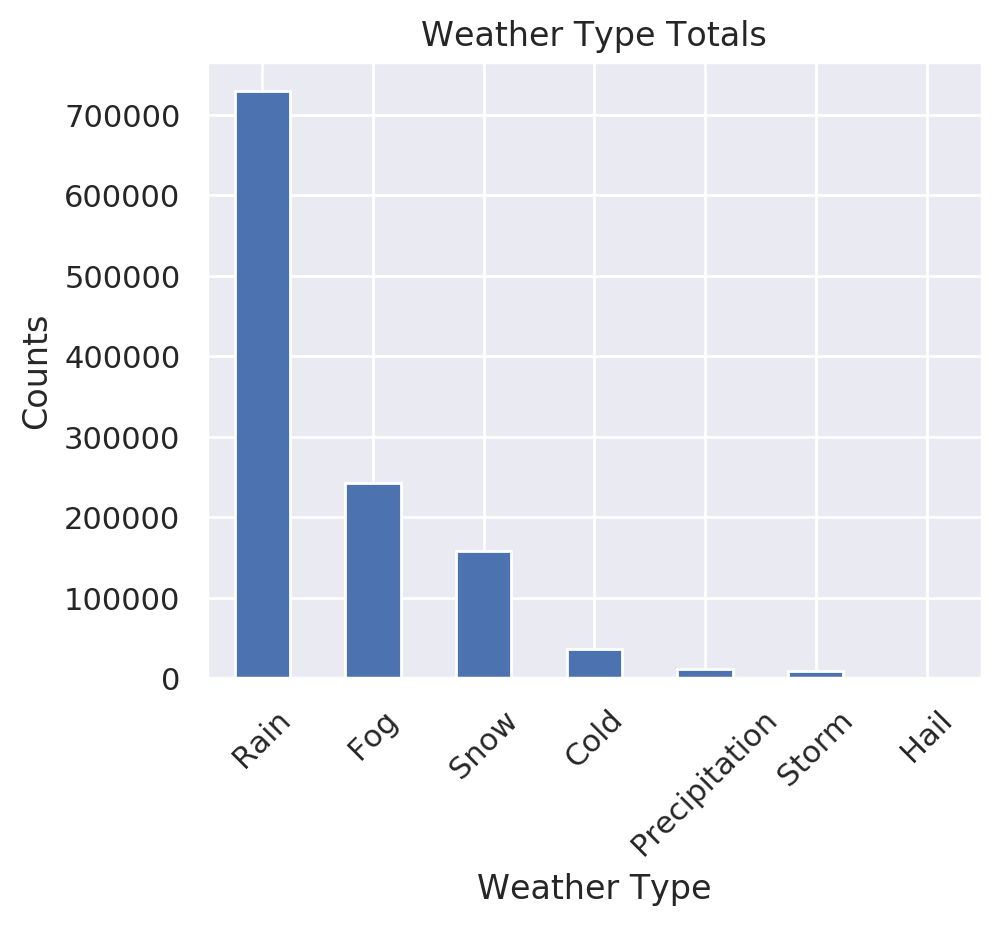

In [195]:
sns.set(rc={'figure.figsize':(5,4)})

weather_df['Type'].value_counts().plot(kind='bar')
plt.title('Weather Type Totals')
plt.xlabel('Weather Type')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

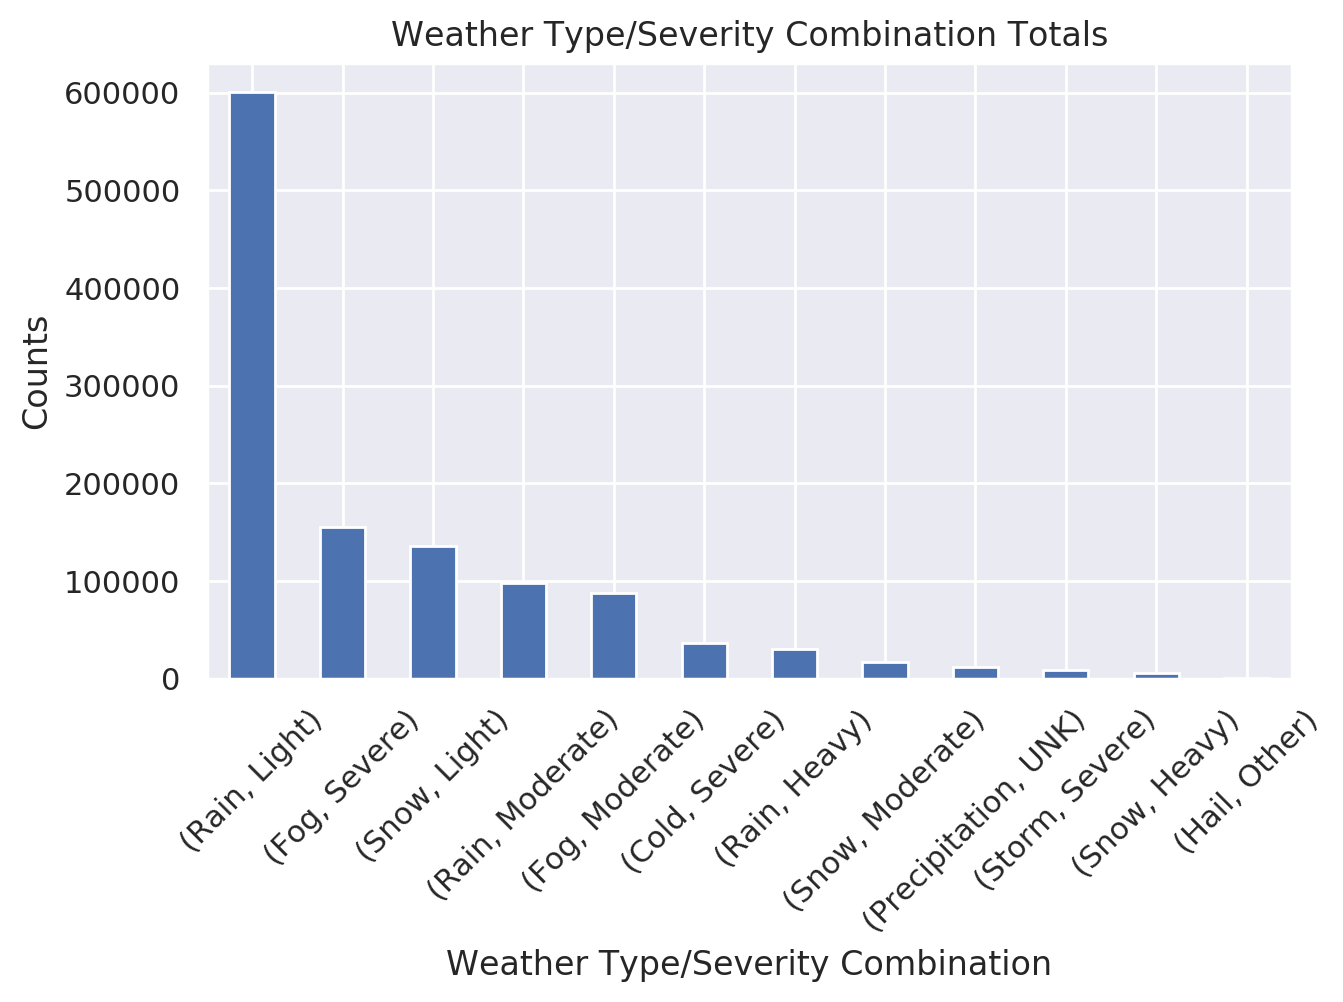

In [196]:
plt.subplots(figsize=(7, 4))

weather_df[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

What are the weather type/severity distributions for JFK in particular?

In [197]:
weather_JFK = weather_df[weather_df["AirportCode"]=="JFK"].reset_index()

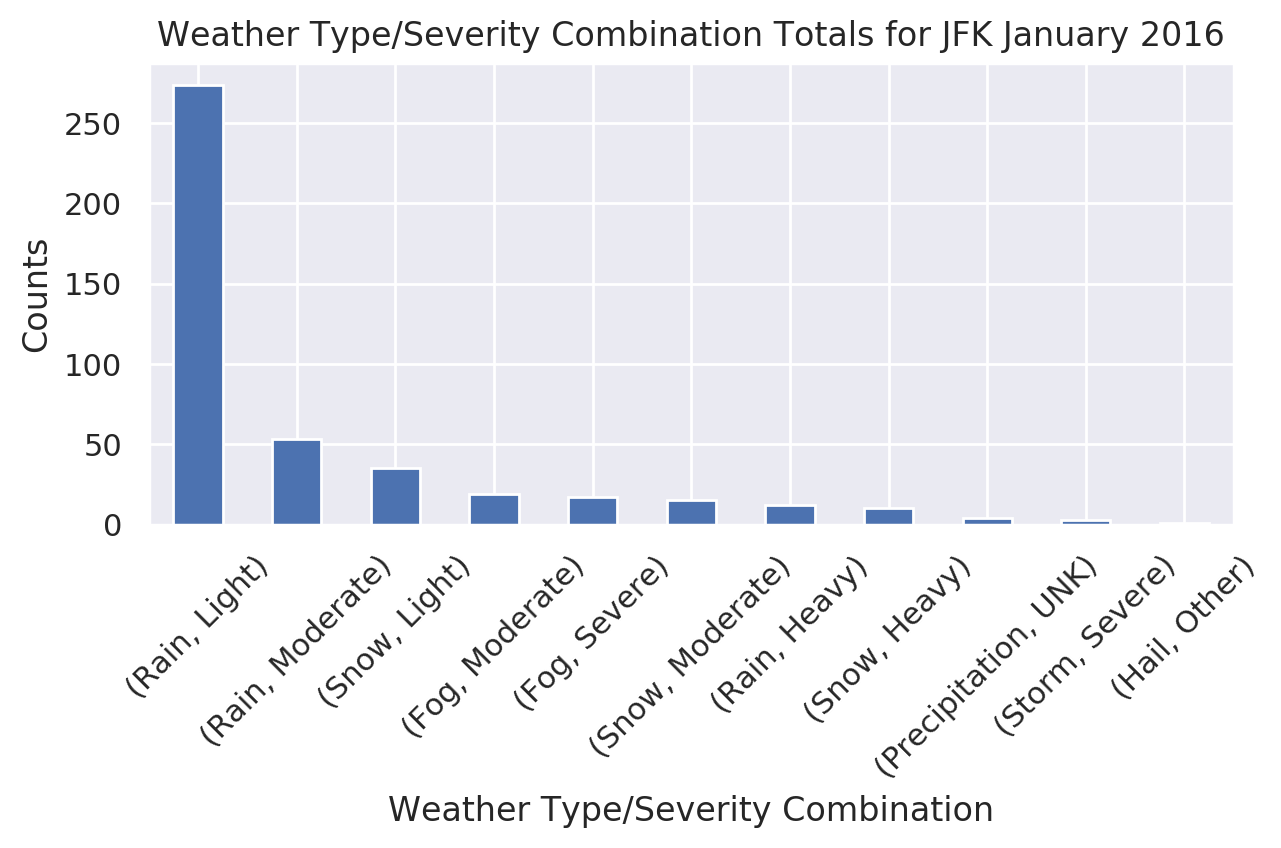

In [198]:
plt.subplots(figsize=(7, 3))

weather_JFK[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals for JFK January 2016')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

What is the timeline of JFK weather conditions?

In [199]:
JFK_weather_data.head(20)

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0
5,2016-01-06,40.0,21.0,30.5,-3.2,34,0,0,0,0
6,2016-01-07,46.0,27.0,36.5,3,28,0,0,0,0
7,2016-01-08,47.0,32.0,39.5,6.1,25,0,0,0,0
8,2016-01-09,53.0,40.0,46.5,13.3,18,0,0.02,0,0
9,2016-01-10,58.0,41.0,49.5,16.4,15,0,1.28,0,0


In [200]:
JFK_weather_data.iloc[0:30].head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0


[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09')]

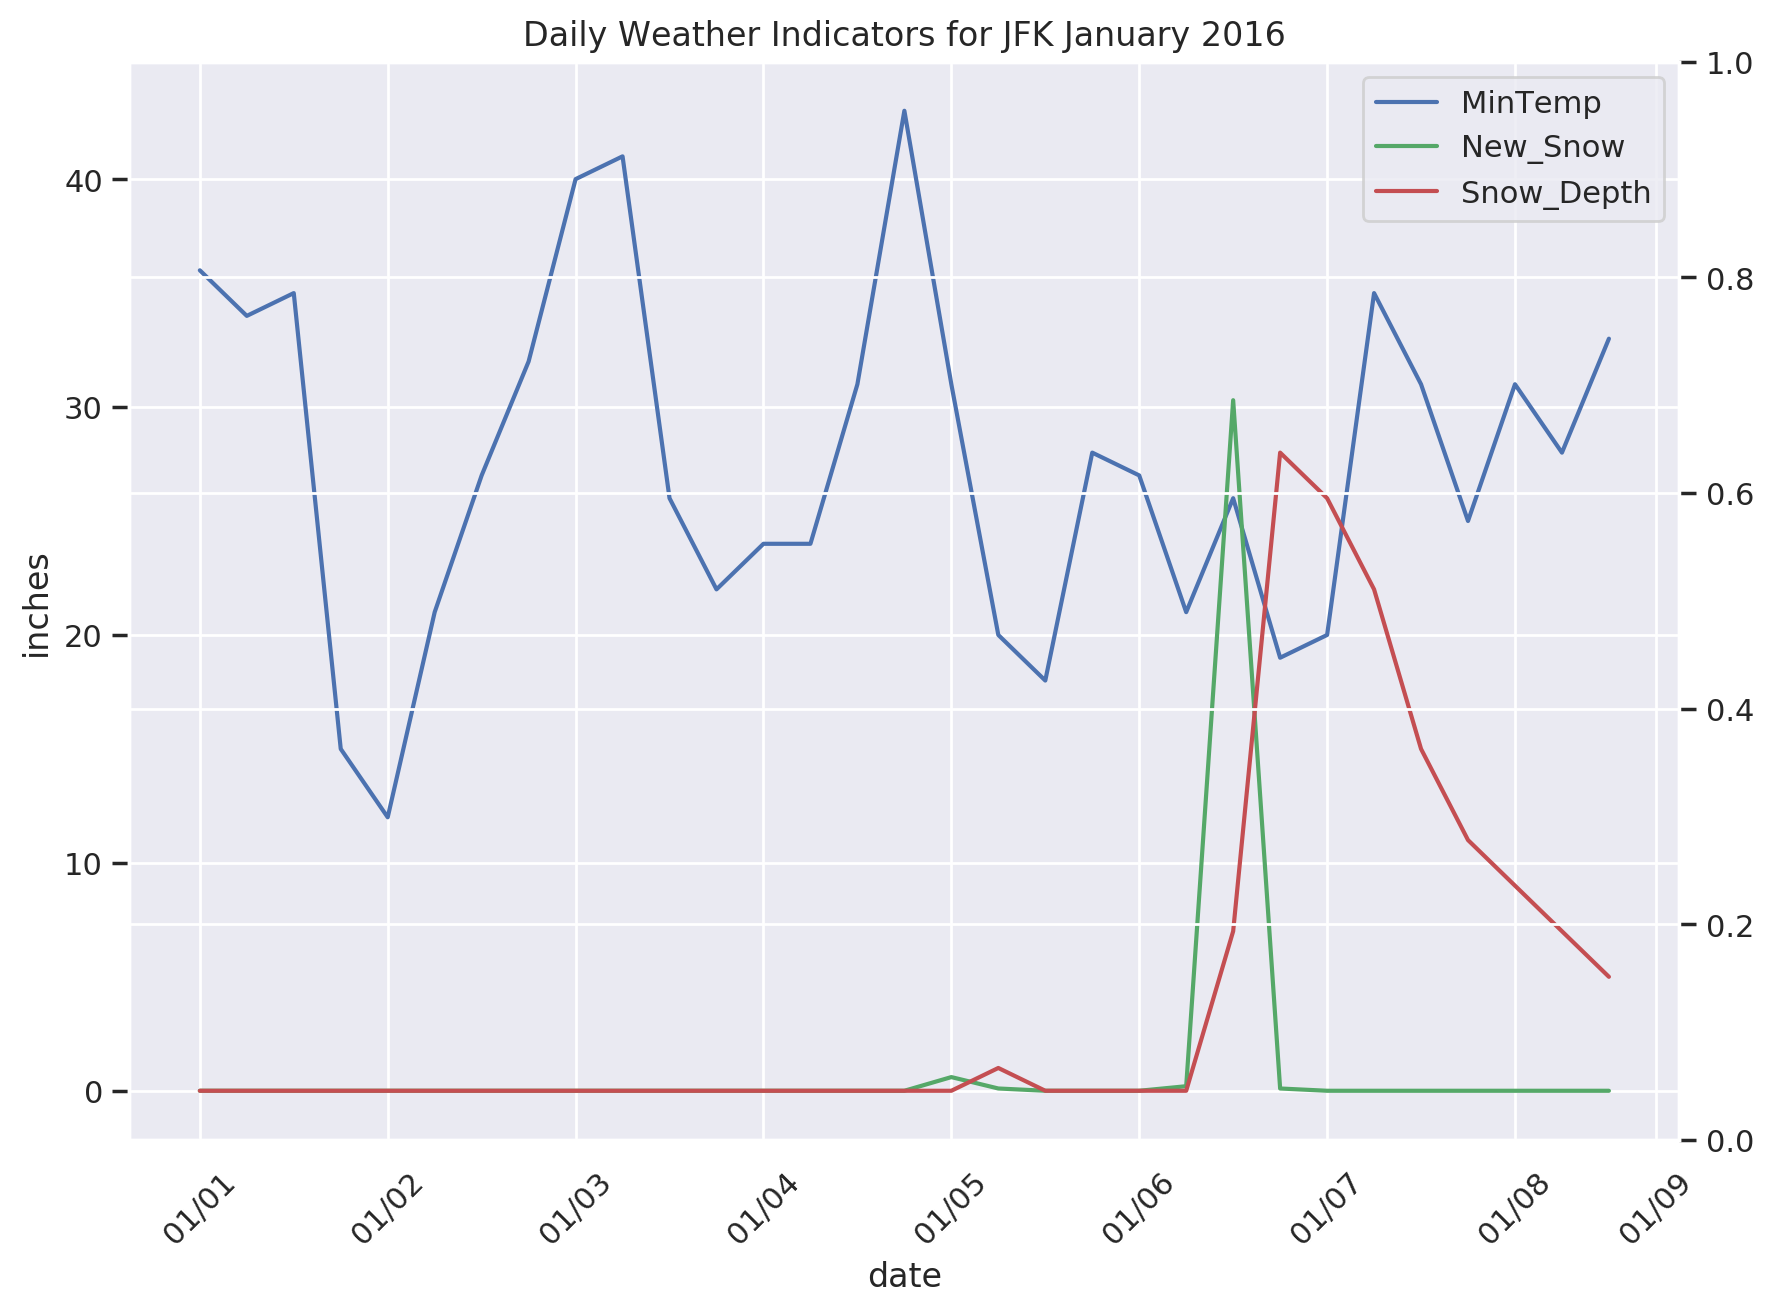

In [204]:
#sns.set(rc={'figure.figsize':(10,9)})

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_title("Daily Weather Indicators for JFK January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "MinTemp", ax = ax1, color = 'b') # plots the first set
g1. legend (labels =["MinTemp"])

g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "New_Snow", ax = ax1, color = 'g') # plots the second set 
g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "Snow_Depth", ax = ax1, color = 'r') # plots the second set 

g1. legend (labels =["MinTemp","New_Snow","Snow_Depth"])
g1.set(xlabel ="date", ylabel = "inches")
g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)